# Examining UK Deaths by Week

[Go to Summary and Colo(u)rful Plots](#summary)

## Optional: (Re)Download UK Weekly Deaths

If you're just examining the data once, this is overkill. Just go [here](https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/weeklyprovisionalfiguresondeathsregisteredinenglandandwales) and click on 5-10 links to download the files you want.

This is useful to automatically download the to latest spreadsheets (updated weekly).

### Imports

`requests`, `BeautifulSoup`, `Path`, `np`, `pd`, `time`, `datetime`, `plt`

In [1]:
import requests
from bs4 import BeautifulSoup
from pathlib import Path
import numpy as np
import pandas as pd
import time
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

### Download and Extract List of Data Files

In [8]:
# path to where ONS weekly deaths files will be stored
data_path = Path('/home/dc/data/uk_ons_weekly')

# only download this year's spreadsheet? If this is your first time downloading the data, set this to False.
current_year_only = True

Request the page from ONS's website.

In [9]:
ons_weekly_url = 'https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/weeklyprovisionalfiguresondeathsregisteredinenglandandwales'

r = requests.get(ons_weekly_url)
assert r.ok and r.status_code == 200, f'r.ok:{r.ok}, r.status_code:{r.status_code}'

Use BeautifulSoup to extract the list of all .xls and .xlsx files found on this page.

In [10]:
# extract urls linking to .xls and .xlsx files
soup = BeautifulSoup(r.content)
data_urls = [a.attrs['href'] for a in soup.find_all('a') 
             if a.has_attr('href') and a.attrs['href'].split('.')[-1] in ('xlsx', 'xls')]
data_urls = ['https://www.ons.gov.uk' + url for url in data_urls]
data_urls

['https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2020/publishedweek172020.xlsx',
 'https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2019/publishedweek522019.xls',
 'https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2018/publishedweek522018withupdatedrespiratoryrow.xls',
 'https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2017/publishedweek522017.xls',
 'https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresond

### Download and Save Data Files

If `current_year_only == True`, download and save the data for the current year. Otherwise, download all files.

In [11]:
def sleep(x): time.sleep(x); return True

if current_year_only:
    time.sleep(1)
    assert str(datetime.now().year) in data_urls[0] # ensure the first spreadsheet we found is for this year
    r_xls_files = [requests.get(data_urls[0])]
else:
    # download list of files, waiting 1 second between requests
    r_xls_files = [requests.get(url) for url in data_urls if sleep(1)]
    len(r_xls_files), [r.ok for r in r_xls_files]

print('Downloaded files:')
[f.url for f in r_xls_files]

Downloaded files:


['https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2020/publishedweek172020.xlsx']

Save downloaded files in the `data_path`. This will overwrite existing files if they've been downloaded before.

In [12]:
# ensure data folder exists
data_path.mkdir(parents=True, exist_ok=True)

# write files to disk
for r in r_xls_files:
    filename = r.url.split('%2f')[-1].replace('/','_')
    with open(data_path / filename, 'wb') as f:
        f.write(r.content)

### Load All Files From Disk

Get list of filenames in `data_path` directory.

In [13]:
# find the latest week available for each year
filenames = sorted(list(f.name for f in data_path.glob('*_publishedweek*')))
filename_by_year = {int(f.split('_')[0]):f for f in filenames}
years = list(filename_by_year.keys())

filename_by_year

{2010: '2010_publishedweek2010.xls',
 2011: '2011_publishedweek2011.xls',
 2012: '2012_publishedweek2012.xls',
 2013: '2013_publishedweek2013.xls',
 2014: '2014_publishedweek2014.xls',
 2015: '2015_publishedweek2015.xls',
 2016: '2016_publishedweek522016.xls',
 2017: '2017_publishedweek522017.xls',
 2018: '2018_publishedweek522018withupdatedrespiratoryrow.xls',
 2019: '2019_publishedweek522019.xls',
 2020: '2020_publishedweek172020.xlsx'}

Read in all sheets for the year 2020.

In [14]:
# read a file from `data_path` directory
filename = filename_by_year[2020]

with open(data_path / filename, 'rb') as f:
    data = pd.read_excel(f, sheet_name=None) # sheet_name=None gets all sheets

sheet_names = list(data.keys())
sheet_names

['Analysis',
 'Contents',
 'Information',
 'Terms and conditions',
 'Weekly figures 2020',
 'Covid-19 - Weekly registrations',
 'Covid-19 - Weekly occurrences',
 'UK - Covid-19 - Weekly reg',
 'Covid-19 - E&W comparisons',
 'Covid-19 - England comparisons',
 'Covid-19 - Wales comparison',
 'Covid-19 - Place of occurrence ',
 'Related publications']

View the weekly figures sheet. Warning, it's pretty ugly!

In [15]:
weekly_sheet_name = [s for s in sheet_names if s.lower().startswith('weekly figures')][0]
print('sheet name:', weekly_sheet_name)
weekly_deaths_2020 = data[weekly_sheet_name]
weekly_deaths_2020[:15]

sheet name: Weekly figures 2020


,Contents,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54
0,Weekly provisional figures on deaths registere...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Note that up-to-date counts of the total numbe...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Week number,NaN,1,2,3,4,5,6,7,8,...,44,45,46,47,48,49,50,51,52,53
4,Week ended,NaN,2020-01-03 00:00:00,2020-01-10 00:00:00,2020-01-17 00:00:00,2020-01-24 00:00:00,2020-01-31 00:00:00,2020-02-07 00:00:00,2020-02-14 00:00:00,2020-02-21 00:00:00,...,2020-10-30 00:00:00,2020-11-06 00:00:00,2020-11-13 00:00:00,2020-11-20 00:00:00,2020-11-27 00:00:00,2020-12-04 00:00:00,2020-12-11 00:00:00,2020-12-18 00:00:00,2020-12-25 00:00:00,2021-01-01 00:00:00
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,"Total deaths, all ages",NaN,12254,14058,12990,11856,11612,10986,10944,10841,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Total deaths: average of corresponding,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,week over the previous 5 years 1 (England and ...,NaN,12175,13822,13216,12760,12206,11925,11627,11548,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Okay, what we really want to get out of here is the total deaths, deaths by age, and deaths by location.

I'd like to point out that this spreadsheet also includes respiratory deaths and deaths by age+gender, but I'm ignoring this data for now.

### Extract data for the year 2020

`deaths2020_total`, `deaths2020_by_age`, `deaths2020_by_location`

In [16]:
weekly_deaths_2020[70:100]

,Contents,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54
70,NaN,25-29,10,9,6,5,9,12,8,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,NaN,30-34,11,18,18,16,18,14,13,21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,NaN,35-39,22,22,28,34,31,18,33,31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,NaN,40-44,26,33,46,37,42,40,34,45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,NaN,45-49,53,77,83,70,56,62,66,77,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,NaN,50-54,102,123,106,99,98,114,116,92,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,NaN,55-59,170,167,166,166,135,163,136,151,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,NaN,60-64,211,249,224,201,201,206,203,226,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78,NaN,65-69,281,348,332,309,295,266,241,295,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79,NaN,70-74,467,580,520,504,513,494,453,450,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
def extract_row(row_ix, data):
    row = data.iloc[row_ix, :]
    row = [x for x in row if not pd.isna(x)]
    return row

def extract_total_deaths(weekly_deaths_2020):
    row = extract_row(7, weekly_deaths_2020)
    assert row[0] == 'Total deaths, all ages'
    return row[1:]
def extract_deaths_by_age(weekly_deaths_2020):
    rows = [extract_row(i, weekly_deaths_2020) for i in range(19,40)]
    assert rows[0][0] == 'Deaths by age group'
    assert rows[-1][0] == '90+'
    return {r[0]:r[1:] for r in rows[1:]}
def extract_deaths_by_location(weekly_deaths_2020):
    rows = [extract_row(i, weekly_deaths_2020) for i in range(84,95)]
    assert rows[0][0] == 'Deaths by region of usual residence 7'
    assert rows[-1][1] == 'Wales'
    return {r[1]:r[2:] for r in rows[1:]}
    
deaths2020_total = extract_total_deaths(weekly_deaths_2020)
deaths2020_by_age = extract_deaths_by_age(weekly_deaths_2020)
deaths2020_by_location = extract_deaths_by_location(weekly_deaths_2020)

## Prepare Data for Plotting UK Weekly Deaths

### Import Python Libraries

`np`, `pd`, `plt`

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

### Import Data

Populate `deaths` dictionary.

Download the spreadsheets from [UK Office of National Statistics - Weekly Deaths](https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/weeklyprovisionalfiguresondeathsregisteredinenglandandwales) or use the above section to automatically download the data.

I did this on 13 Apr, 2020, which includes weekly deaths up to 27 Mar, 2020.

In [19]:
def import_row(raw_text, dtype=np.int):
    lines = raw_text.strip().split('\n')
    strings = np.array([l.replace(',','').split('\t') for l in lines])
    return strings if dtype is None else strings.astype(dtype)

def import_table(raw, dtype=np.int):
    array = import_row(raw, dtype=None)
    return pd.DataFrame(array[:,1:].transpose(), columns=array[:,0], dtype=dtype)

In [20]:
deaths = {}

#### Manual Data Entry

In [21]:
##############
## TEMPLATE ##
##############

#### Usage: 
## 1. copy-paste the text below into a new cell (Ctrl+C, Ctrl+V)
## 2. highlight text (Ctrl+A)
## 3. uncomment (Ctrl+/)
## 4. change the year as needed
## 4. copy-paste the relevant cells from the data into the comment blocks
####

# year = 2020
# raw_deaths_total  = ''''''
# raw_deaths_by_age = ''''''
# raw_deaths_by_loc = ''''''

# deaths[year] = {}
# deaths[year]['total'] = import_row(raw_deaths_total)
# deaths[year]['age'] = import_table(raw_deaths_by_age)
# deaths[year]['location'] = import_table(raw_deaths_by_loc)

In [22]:
year = 2020
raw_deaths_total  = '''12,254	14,058	12,990	11,856	11,612	10,986	10,944	10,841	10,816	10,895	11,019	10,645	11,141'''
raw_deaths_by_age = '''Under 1 year	48	50	69	53	50	31	43	51	49	56	53	44	49
01-14	16	26	15	21	15	16	12	18	20	20	22	12	13
15-44	189	275	313	314	308	271	284	321	314	313	311	275	282
45-64	1,202	1,500	1,517	1,357	1,349	1,331	1,289	1,271	1,257	1,252	1,341	1,263	1,301
65-74	1,860	2,198	2,013	1,958	1,927	1,808	1,753	1,744	1,795	1,769	1,754	1,780	1,805
75-84	3,583	4,014	3,715	3,337	3,257	3,056	3,008	3,032	2,967	3,124	3,104	3,066	3,247
85+	5,356	5,995	5,348	4,816	4,706	4,473	4,555	4,404	4,414	4,361	4,434	4,205	4,444'''
raw_deaths_by_loc = '''North East	673	707	647	612	561	564	573	539	572	568	590	522	542
North West	1,806	1,932	1,696	1,529	1,461	1,529	1,427	1,477	1,476	1,490	1,472	1,443	1,538
Yorkshire and The Humber	1,240	1,339	1,278	1,187	1,136	1,072	1,059	1,087	1,078	1,112	1,053	1,012	982
East Midlands	1,060	1,195	1,106	1,024	1,015	922	976	924	919	930	915	947	922
West Midlands	1,349	1,450	1,407	1,231	1,262	1,052	1,159	1,116	1,174	1,098	1,187	1,115	1,035
East	1,162	1,573	1,457	1,410	1,286	1,259	1,172	1,167	1,115	1,149	1,211	1,043	1,182
London	1,113	1,272	1,073	1,028	1,092	987	967	1,032	1,085	982	964	1,008	1,297
South East	1,814	2,132	2,064	1,833	1,820	1,729	1,688	1,675	1,587	1,726	1,751	1,657	1,822
South West	1,225	1,487	1,466	1,253	1,233	1,157	1,169	1,118	1,133	1,170	1,174	1,156	1,092
Wales	787	939	767	723	727	690	728	679	651	652	675	719	719'''

deaths[year] = {}
deaths[year]['total'] = import_row(raw_deaths_total)
deaths[year]['age'] = import_table(raw_deaths_by_age)
deaths[year]['location'] = import_table(raw_deaths_by_loc)

In [23]:
year = 2019
raw_deaths_total  = '''10,955	12,609	11,860	11,740	11,297	11,660	11,824	11,295	11,044	10,898	10,567	10,402	9,867	10,126	10,291	9,025	10,059	11,207	9,055	10,272	10,284	8,260	10,140	9,445	9,458	9,511	9,062	9,179	9,080	9,112	9,271	9,122	9,093	8,994	8,242	9,695	9,513	9,440	9,517	9,799	9,973	10,156	10,021	10,164	10,697	10,650	10,882	10,958	10,816	11,188	11,926	7,533'''
raw_deaths_by_age = '''Under 1 year	43	50	59	42	57	54	49	59	52	45	57	49	45	41	47	48	34	46	56	44	51	45	48	46	46	39	33	44	45	57	57	57	54	47	45	54	60	45	55	68	46	54	49	45	52	46	57	56	50	52	53	34
01-14	15	20	29	22	15	25	17	30	20	16	24	24	17	13	23	21	18	18	17	14	21	16	18	18	20	21	26	16	14	14	11	12	24	8	16	19	12	18	14	15	16	14	14	19	7	19	19	14	17	32	19	13
15-44	215	280	319	339	307	267	305	276	288	303	299	293	289	296	288	251	273	297	262	304	309	239	306	298	279	273	255	259	279	267	265	245	277	264	224	268	297	264	269	325	302	303	281	289	314	271	283	312	315	315	368	148
45-64	1,199	1,419	1,373	1,438	1,367	1,387	1,372	1,395	1,264	1,342	1,311	1,249	1,222	1,232	1,265	1,100	1,207	1,334	1,094	1,274	1,262	991	1,223	1,149	1,150	1,214	1,112	1,140	1,136	1,117	1,123	1,095	1,244	1,127	1,026	1,199	1,169	1,174	1,197	1,189	1,137	1,154	1,198	1,196	1,236	1,254	1,225	1,237	1,275	1,313	1,316	773
65-74	1,766	2,179	2,004	1,936	1,852	1,955	1,911	1,824	1,826	1,857	1,718	1,713	1,643	1,614	1,712	1,446	1,730	1,869	1,513	1,650	1,765	1,382	1,741	1,658	1,625	1,605	1,561	1,564	1,500	1,598	1,597	1,578	1,573	1,582	1,419	1,643	1,617	1,592	1,547	1,665	1,595	1,628	1,663	1,663	1,676	1,673	1,743	1,751	1,689	1,793	1,903	1,185
75-84	3,078	3,590	3,414	3,266	3,126	3,251	3,392	3,169	3,117	3,042	2,933	2,948	2,794	2,937	2,907	2,547	2,811	3,207	2,579	2,864	2,946	2,403	2,846	2,672	2,711	2,692	2,650	2,616	2,610	2,580	2,664	2,575	2,530	2,479	2,319	2,775	2,654	2,695	2,760	2,780	2,869	2,920	2,799	2,938	2,998	3,070	3,163	3,142	3,078	3,215	3,299	2,231
85+	4,639	5,071	4,662	4,697	4,573	4,721	4,778	4,542	4,477	4,293	4,225	4,126	3,857	3,993	4,049	3,612	3,986	4,436	3,534	4,122	3,930	3,184	3,958	3,604	3,627	3,667	3,425	3,540	3,496	3,479	3,554	3,560	3,391	3,487	3,193	3,737	3,704	3,652	3,675	3,757	4,008	4,083	4,017	4,014	4,414	4,317	4,392	4,446	4,392	4,468	4,968	3,149
'''
raw_deaths_by_loc = '''North East	574	643	627	640	618	608	569	610	572	582	527	532	529	518	510	459	551	541	484	548	530	436	554	507	478	475	437	458	478	534	536	530	497	505	466	473	482	494	538	491	527	567	540	537	553	607	582	563	558	585	670	411
North West	1,456	1,612	1,566	1,593	1,485	1,595	1,618	1,495	1,425	1,463	1,393	1,437	1,278	1,277	1,341	1,225	1,365	1,493	1,214	1,402	1,397	1,176	1,349	1,313	1,344	1,250	1,269	1,272	1,287	1,237	1,234	1,149	1,237	1,203	1,153	1,248	1,328	1,283	1,299	1,322	1,400	1,400	1,361	1,338	1,455	1,402	1,464	1,469	1,477	1,637	1,712	1,200
Yorkshire and The Humber	1,148	1,279	1,197	1,137	1,131	1,133	1,189	1,124	1,109	1,083	1,054	1,087	943	959	1,034	910	996	1,125	924	980	1,024	782	1,025	889	931	984	896	932	841	895	936	867	857	927	832	937	916	954	906	948	1,005	1,019	1,001	1,033	1,053	1,070	1,039	1,139	1,011	1,102	1,173	737
East Midlands	964	1,089	979	1,037	963	988	1,033	928	927	946	879	890	875	876	858	759	856	986	776	887	888	699	880	817	751	790	750	747	809	774	782	795	749	726	697	867	774	827	842	875	847	863	846	877	880	889	931	935	958	973	1,050	729
West Midlands	1,180	1,299	1,187	1,131	1,150	1,241	1,231	1,143	1,188	1,150	1,092	1,062	930	1,050	1,084	928	1,008	1,136	906	1,082	1,070	840	1,082	950	938	1,013	940	949	962	882	929	953	969	918	826	939	1,001	974	1,027	1,008	1,027	1,093	1,019	967	1,110	1,080	1,138	1,184	1,083	1,130	1,269	720
East	1,136	1,386	1,344	1,291	1,202	1,283	1,342	1,218	1,214	1,116	1,198	1,066	1,136	1,224	1,188	1,014	1,084	1,139	943	1,112	1,097	842	982	1,012	1,011	1,028	981	995	994	1,024	988	1,026	933	964	838	1,115	1,088	1,049	1,014	1,059	1,073	1,083	1,063	1,100	1,181	1,090	1,166	1,116	1,184	1,176	1,238	716
London	1,021	1,137	1,073	1,045	1,066	1,088	1,061	1,045	1,009	1,004	975	925	910	928	937	834	951	1,040	807	927	876	809	919	900	900	892	833	875	829	833	911	891	892	826	784	976	916	889	840	846	887	886	895	976	974	1,041	1,023	1,025	986	1,044	1,028	653
South East	1,586	1,927	1,936	1,875	1,718	1,738	1,802	1,777	1,712	1,708	1,601	1,640	1,540	1,582	1,623	1,350	1,495	1,782	1,456	1,570	1,620	1,252	1,516	1,452	1,510	1,481	1,431	1,357	1,328	1,376	1,424	1,334	1,355	1,389	1,245	1,518	1,399	1,385	1,404	1,573	1,557	1,556	1,491	1,547	1,701	1,690	1,618	1,648	1,647	1,690	1,709	1,094
South West	1,136	1,394	1,236	1,229	1,191	1,251	1,207	1,234	1,178	1,198	1,149	1,089	1,047	1,039	1,037	919	1,053	1,251	922	1,078	1,126	886	1,182	986	1,032	1,005	962	972	981	982	926	1,010	978	963	814	1,014	1,020	982	1,017	1,059	1,026	1,040	1,107	1,118	1,102	1,083	1,203	1,166	1,157	1,130	1,288	766
Wales	718	809	683	734	745	701	748	695	684	622	666	628	654	642	637	580	678	688	600	658	627	518	626	598	542	564	534	588	553	543	570	542	589	553	558	582	567	572	611	597	590	622	670	642	653	674	699	689	737	699	767	496
'''

deaths[year] = {}
deaths[year]['total'] = import_row(raw_deaths_total)
deaths[year]['age'] = import_table(raw_deaths_by_age)
deaths[year]['location'] = import_table(raw_deaths_by_loc)

In [24]:
year = 2018
raw_deaths_total  = '''12,723	15,050	14,256	13,935	13,285	12,495	12,246	12,142	10,854	12,997	12,788	11,913	9,941	10,794	12,301	11,223	10,306	10,153	8,624	10,141	9,636	8,147	9,950	9,343	9,256	9,212	9,258	9,293	9,127	9,141	9,161	9,319	8,830	8,978	7,865	9,445	9,191	9,305	9,150	9,503	9,649	9,864	9,603	9,529	10,151	10,193	9,957	10,033	10,287	10,550	11,116	7,131'''
raw_deaths_by_age = '''Under 1 year	52	73	59	50	41	45	48	26	45	47	47	46	43	46	36	54	57	51	48	52	60	46	46	60	55	43	50	48	45	59	62	59	64	44	51	45	55	69	50	40	47	43	65	46	44	47	62	58	45	51	41	22
01-14	18	17	22	25	14	23	17	13	11	27	17	15	20	22	25	21	12	21	21	24	13	18	19	17	21	22	23	21	15	13	18	18	11	22	11	20	18	18	10	17	20	18	24	24	12	29	22	20	15	13	23	11
15-44	208	302	286	298	339	293	318	294	254	287	329	278	261	260	337	301	340	308	247	300	294	250	298	286	308	306	286	304	304	291	286	328	253	250	233	323	275	292	270	287	328	301	309	289	308	292	312	317	326	295	333	166
45-64	1,290	1,561	1,507	1,459	1,404	1,347	1,377	1,378	1,229	1,362	1,316	1,349	1,065	1,229	1,382	1,386	1,213	1,363	1,115	1,330	1,258	998	1,195	1,199	1,161	1,184	1,150	1,140	1,166	1,193	1,155	1,175	1,130	1,083	1,017	1,196	1,180	1,171	1,083	1,200	1,212	1,209	1,200	1,151	1,157	1,238	1,223	1,246	1,218	1,265	1,306	792
65-74	1,976	2,321	2,191	2,157	1,988	2,032	1,953	1,896	1,728	2,019	1,989	1,917	1,586	1,764	2,053	1,880	1,707	1,725	1,437	1,760	1,659	1,431	1,700	1,607	1,613	1,652	1,548	1,600	1,577	1,566	1,536	1,608	1,558	1,601	1,442	1,621	1,600	1,623	1,607	1,627	1,607	1,654	1,657	1,569	1,666	1,716	1,700	1,658	1,696	1,814	1,867	1,205
75-84	3,612	4,155	3,866	3,824	3,661	3,376	3,492	3,398	3,028	3,691	3,594	3,342	2,884	3,013	3,442	3,109	2,906	2,907	2,384	2,791	2,687	2,330	2,881	2,670	2,550	2,508	2,611	2,633	2,484	2,628	2,620	2,563	2,489	2,560	2,150	2,638	2,576	2,601	2,629	2,696	2,741	2,769	2,642	2,700	2,949	2,819	2,766	2,829	2,965	2,962	3,136	2,013
85+	5,565	6,621	6,325	6,122	5,838	5,374	5,041	5,137	4,559	5,564	5,496	4,966	4,082	4,460	5,026	4,472	4,071	3,778	3,372	3,884	3,665	3,074	3,811	3,504	3,548	3,497	3,590	3,547	3,536	3,391	3,484	3,568	3,325	3,418	2,961	3,602	3,487	3,531	3,501	3,636	3,694	3,870	3,706	3,750	4,015	4,052	3,872	3,905	4,022	4,150	4,410	2,922
'''
raw_deaths_by_loc = '''North East	640	837	783	779	740	663	612	671	551	677	614	576	498	534	631	559	516	534	510	504	501	458	548	454	475	484	477	470	471	477	486	448	446	477	437	534	465	475	483	514	486	527	526	511	520	490	511	505	539	561	625	459
North West	1,747	2,113	1,828	1,855	1,728	1,615	1,665	1,677	1,485	1,690	1,690	1,516	1,335	1,470	1,613	1,456	1,391	1,347	1,116	1,390	1,278	1,142	1,309	1,167	1,217	1,214	1,280	1,239	1,229	1,219	1,228	1,231	1,171	1,134	1,058	1,152	1,231	1,226	1,262	1,302	1,291	1,274	1,215	1,330	1,403	1,408	1,357	1,330	1,377	1,422	1,439	1,020
Yorkshire and The Humber	1,300	1,481	1,387	1,363	1,285	1,206	1,230	1,196	1,125	1,192	1,203	1,124	973	1,105	1,199	1,037	987	922	886	888	913	769	985	947	944	882	895	901	942	907	817	913	880	913	779	956	865	912	904	948	963	968	956	964	981	969	1,013	998	1,006	1,108	1,148	688
East Midlands	1,085	1,266	1,175	1,165	1,154	1,109	1,024	1,034	907	1,072	1,116	1,038	819	886	1,068	986	904	892	740	943	828	716	884	777	764	822	788	758	730	762	830	793	742	780	630	804	814	776	766	781	832	815	880	810	813	899	848	838	830	873	930	651
West Midlands	1,313	1,468	1,544	1,433	1,441	1,335	1,285	1,251	1,308	1,390	1,343	1,263	1,019	1,054	1,228	1,170	969	1,113	823	1,105	983	859	1,065	967	971	954	998	961	949	897	961	946	910	983	793	1,005	956	947	965	1,020	980	979	1,079	890	1,081	1,047	1,001	1,076	1,098	1,034	1,145	660
East	1,404	1,677	1,562	1,553	1,468	1,359	1,307	1,300	1,088	1,390	1,358	1,251	1,074	1,196	1,425	1,248	1,209	1,117	937	1,125	1,053	839	1,157	991	985	1,011	940	993	953	1,008	1,010	1,028	991	993	877	996	999	990	957	990	1,071	1,045	993	1,042	1,094	1,128	1,071	1,077	1,106	1,130	1,124	695
London	1,130	1,342	1,239	1,264	1,208	1,041	1,171	1,105	1,060	1,177	1,121	1,095	910	1,014	1,133	1,039	947	917	841	913	932	784	890	921	855	824	814	941	905	955	883	947	870	808	741	904	834	865	868	898	860	941	905	896	925	940	903	948	958	1,007	1,035	655
South East	1,902	2,371	2,287	2,184	2,046	1,867	1,810	1,757	1,611	1,919	1,954	1,853	1,518	1,578	1,883	1,743	1,613	1,570	1,294	1,511	1,512	1,187	1,435	1,442	1,448	1,408	1,426	1,403	1,373	1,374	1,396	1,453	1,361	1,392	1,170	1,464	1,440	1,503	1,375	1,387	1,491	1,570	1,376	1,465	1,543	1,538	1,503	1,523	1,594	1,573	1,688	1,062
South West	1,393	1,552	1,535	1,460	1,382	1,378	1,283	1,314	997	1,560	1,414	1,283	1,047	1,142	1,293	1,212	1,117	1,082	929	1,068	997	830	1,057	1,085	1,019	983	991	1,025	971	941	957	997	902	900	845	1,000	986	986	965	1,020	1,043	1,088	1,004	988	1,106	1,077	1,062	1,040	1,076	1,106	1,225	756
Wales	783	904	885	850	815	801	803	789	634	896	918	774	633	730	743	688	614	633	530	667	603	538	607	561	562	599	625	583	548	560	574	537	518	565	511	594	579	598	560	595	606	640	633	604	642	656	657	673	674	708	724	461
'''

deaths[year] = {}
deaths[year]['total'] = import_row(raw_deaths_total)
deaths[year]['age'] = import_table(raw_deaths_by_age)
deaths[year]['location'] = import_table(raw_deaths_by_loc)

In [25]:
year = 2017
raw_deaths_total  = '''11,991	13,715	13,610	12,877	12,485	12,269	11,644	11,794	11,248	11,077	10,697	10,325	10,027	9,939	8,493	9,644	10,908	9,064	10,693	10,288	10,040	8,332	9,766	9,367	9,627	9,334	9,263	9,376	9,113	8,882	8,941	9,038	9,299	9,382	8,149	9,497	9,454	9,534	9,689	9,778	9,940	10,031	9,739	9,984	10,346	10,275	10,621	10,538	10,781	11,217	12,517	8,487'''
raw_deaths_by_age = '''Under 1 year	58	56	54	52	55	57	49	47	53	54	59	55	65	59	38	68	70	44	41	38	71	49	57	60	65	54	60	56	64	37	47	55	50	51	45	53	48	49	45	66	48	62	54	40	47	48	50	56	58	39	52	23
01-14	18	18	19	16	14	17	18	20	22	17	7	13	20	21	20	19	20	18	23	18	21	12	27	20	17	13	23	23	19	15	12	17	20	11	18	17	18	21	27	20	11	13	25	18	20	9	20	21	20	19	20	18
15-44	215	287	301	286	308	293	295	286	254	316	274	268	307	277	235	280	273	268	323	291	307	223	308	259	300	275	293	270	331	280	269	257	293	286	211	273	277	294	243	284	245	293	269	288	322	308	310	295	268	267	307	172
45-64	1,232	1,372	1,374	1,273	1,239	1,342	1,316	1,298	1,252	1,240	1,260	1,256	1,202	1,181	1,003	1,130	1,315	1,035	1,275	1,320	1,187	995	1,227	1,188	1,175	1,121	1,202	1,144	1,210	1,184	1,131	1,141	1,146	1,095	997	1,190	1,207	1,157	1,160	1,171	1,185	1,165	1,166	1,243	1,251	1,242	1,308	1,216	1,224	1,282	1,397	895
65-74	1,880	2,149	2,132	1,946	1,930	1,940	1,811	1,816	1,823	1,756	1,722	1,739	1,656	1,705	1,468	1,585	1,822	1,529	1,813	1,794	1,722	1,475	1,632	1,663	1,570	1,656	1,622	1,660	1,541	1,539	1,510	1,580	1,568	1,549	1,448	1,613	1,641	1,614	1,686	1,677	1,678	1,731	1,658	1,659	1,734	1,682	1,728	1,737	1,761	1,776	1,995	1,275
75-84	3,450	3,886	3,701	3,652	3,509	3,483	3,242	3,214	3,142	3,086	3,015	2,940	2,838	2,748	2,397	2,834	3,132	2,557	3,019	2,854	2,744	2,361	2,785	2,554	2,715	2,676	2,584	2,694	2,531	2,439	2,542	2,620	2,601	2,667	2,279	2,644	2,628	2,623	2,698	2,677	2,846	2,836	2,765	2,875	2,889	2,901	2,962	2,945	3,027	3,176	3,523	2,444
85+	5,136	5,947	6,029	5,652	5,430	5,129	4,913	5,112	4,699	4,608	4,360	4,054	3,939	3,947	3,330	3,721	4,276	3,613	4,196	3,973	3,983	3,217	3,727	3,619	3,785	3,536	3,477	3,528	3,415	3,388	3,427	3,368	3,617	3,723	3,148	3,703	3,634	3,776	3,830	3,881	3,926	3,929	3,802	3,860	4,081	4,084	4,234	4,266	4,423	4,658	5,220	3,654
'''
raw_deaths_by_loc = '''North East	602	738	676	627	631	635	610	636	606	570	581	535	509	523	410	517	583	479	551	553	519	408	514	499	509	451	495	502	514	456	507	479	464	482	434	512	539	504	507	501	513	550	509	536	510	502	550	562	612	595	719	500
North West	1,665	1,840	1,786	1,666	1,625	1,566	1,528	1,519	1,488	1,464	1,450	1,364	1,313	1,373	1,217	1,362	1,495	1,279	1,368	1,329	1,349	1,208	1,311	1,272	1,328	1,174	1,278	1,225	1,196	1,174	1,192	1,171	1,260	1,299	1,117	1,307	1,285	1,221	1,305	1,289	1,340	1,359	1,375	1,356	1,365	1,381	1,419	1,453	1,538	1,509	1,709	1,194
Yorkshire and The Humber	1,208	1,351	1,383	1,242	1,243	1,224	1,186	1,159	1,123	1,110	1,121	1,065	1,045	929	795	1,010	1,053	872	1,053	1,030	936	818	950	918	901	914	904	953	856	881	891	882	849	848	836	921	877	919	957	946	1,011	1,019	903	1,006	1,042	1,027	1,089	1,045	1,013	1,048	1,181	840
East Midlands	1,016	1,170	1,190	1,116	1,045	1,036	964	954	963	1,038	963	947	870	835	708	812	882	803	988	817	802	726	841	819	841	804	802	862	809	738	784	772	747	783	667	808	758	814	782	818	827	806	743	850	931	898	862	878	970	971	1,039	685
West Midlands	1,243	1,439	1,414	1,362	1,293	1,234	1,243	1,216	1,184	1,163	1,140	1,034	1,024	1,048	868	978	1,125	902	1,059	1,079	1,088	849	1,060	1,016	991	996	985	973	947	941	911	943	936	966	780	1,017	1,001	978	990	1,003	1,001	997	1,058	1,014	1,117	1,096	1,080	1,065	1,066	1,128	1,318	844
East	1,187	1,450	1,484	1,488	1,384	1,411	1,253	1,327	1,328	1,230	1,150	1,134	1,109	1,056	918	996	1,137	956	1,153	1,124	1,118	813	1,016	990	991	1,028	1,010	1,005	970	949	955	1,005	1,018	1,002	853	1,066	990	1,096	1,071	1,057	1,085	1,056	1,037	1,129	1,132	1,091	1,148	1,168	1,139	1,226	1,322	878
London	1,173	1,296	1,276	1,198	1,210	1,161	1,095	1,114	930	969	946	930	888	905	801	896	1,053	804	970	914	953	787	876	829	902	903	820	843	867	783	792	858	929	907	766	866	871	900	882	923	928	934	931	897	931	949	1,038	972	1,008	1,042	1,153	814
South East	1,899	2,161	2,195	1,999	1,920	1,916	1,847	1,834	1,673	1,738	1,593	1,557	1,520	1,522	1,316	1,409	1,678	1,356	1,685	1,639	1,526	1,217	1,527	1,380	1,473	1,456	1,395	1,393	1,389	1,381	1,345	1,346	1,481	1,502	1,205	1,445	1,493	1,422	1,468	1,521	1,497	1,541	1,539	1,473	1,572	1,539	1,623	1,608	1,649	1,765	1,961	1,305
South West	1,228	1,419	1,346	1,278	1,359	1,339	1,217	1,312	1,221	1,144	1,083	1,107	1,064	1,075	863	984	1,159	997	1,155	1,161	1,118	897	1,066	1,015	1,058	1,038	996	1,031	979	963	946	982	998	1,001	908	993	1,006	1,074	1,109	1,063	1,068	1,098	1,020	1,105	1,117	1,103	1,151	1,123	1,140	1,204	1,332	863
Wales	744	825	835	881	749	723	690	701	715	634	653	635	658	642	577	654	727	600	687	615	602	586	584	599	608	546	556	564	551	586	590	572	592	570	555	542	609	585	593	631	640	650	608	595	598	666	639	636	630	708	762	541
'''

deaths[year] = {}
deaths[year]['total'] = import_row(raw_deaths_total)
deaths[year]['age'] = import_table(raw_deaths_by_age)
deaths[year]['location'] = import_table(raw_deaths_by_loc)

In [26]:
year = 2016
raw_deaths_total  = '''13,045	11,501	11,473	11,317	11,052	11,170	10,590	11,056	11,285	11,010	11,022	9,635	10,286	11,599	11,417	10,925	10,413	9,137	10,637	9,953	9,739	7,909	9,873	9,386	9,365	9,228	9,138	9,388	9,350	9,335	9,182	9,172	9,070	9,319	7,923	9,399	9,124	8,945	8,994	9,291	9,719	9,768	9,724	10,152	10,470	10,694	10,603	10,439	11,223	10,533	11,493	8,003'''
raw_deaths_by_age = '''Under 1 year	49	64	50	47	60	60	52	58	39	54	55	55	49	53	63	65	43	55	49	61	63	35	58	49	57	46	49	54	55	39	56	57	42	48	43	48	56	58	53	57	72	50	58	52	54	57	49	58	57	72	56	41
01-14	17	24	18	14	22	21	22	20	21	22	22	18	15	15	18	24	22	23	19	21	19	19	21	22	15	13	18	15	18	15	19	15	17	16	14	23	15	15	15	21	14	21	16	21	15	26	26	15	28	22	16	7
15-44	299	326	345	324	314	331	305	267	318	273	295	247	264	306	311	319	327	348	308	328	326	214	268	255	295	303	287	279	282	312	276	277	276	241	228	283	265	264	297	275	272	276	271	281	278	355	284	345	310	281	339	178
45-64	1,482	1,363	1,293	1,322	1,281	1,356	1,333	1,294	1,328	1,340	1,358	1,148	1,184	1,327	1,312	1,292	1,301	1,075	1,277	1,149	1,185	963	1,181	1,195	1,161	1,192	1,176	1,153	1,115	1,074	1,171	1,183	1,078	1,104	968	1,161	1,170	1,132	1,151	1,115	1,145	1,158	1,239	1,186	1,279	1,225	1,226	1,191	1,266	1,219	1,253	849
65-74	2,179	1,925	1,831	1,859	1,779	1,826	1,720	1,774	1,864	1,755	1,781	1,567	1,698	1,941	1,927	1,816	1,694	1,490	1,768	1,686	1,681	1,445	1,613	1,604	1,549	1,570	1,552	1,634	1,586	1,567	1,542	1,552	1,610	1,577	1,415	1,562	1,583	1,548	1,549	1,647	1,633	1,652	1,567	1,723	1,709	1,703	1,716	1,752	1,808	1,675	1,927	1,269
75-84	3,727	3,283	3,327	3,147	3,181	3,058	2,982	3,127	3,180	3,171	3,070	2,713	2,992	3,238	3,166	3,085	2,927	2,583	2,994	2,855	2,697	2,253	2,875	2,703	2,659	2,573	2,567	2,649	2,638	2,641	2,588	2,557	2,624	2,680	2,233	2,659	2,628	2,564	2,506	2,641	2,746	2,724	2,800	2,833	2,954	2,992	3,062	2,961	3,176	2,943	3,170	2,294
85+	5,292	4,512	4,606	4,599	4,405	4,502	4,175	4,516	4,533	4,390	4,434	3,878	4,079	4,719	4,617	4,324	4,098	3,559	4,218	3,853	3,767	2,980	3,857	3,556	3,625	3,530	3,489	3,603	3,650	3,683	3,524	3,520	3,423	3,652	3,020	3,661	3,406	3,364	3,422	3,531	3,835	3,887	3,773	4,056	4,178	4,332	4,239	4,116	4,578	4,316	4,725	3,364
'''
raw_deaths_by_loc = '''North East	705	600	612	631	620	599	588	582	582	569	552	474	578	606	594	539	571	495	547	533	484	431	542	473	528	488	507	485	538	476	467	492	476	499	398	478	491	435	481	465	520	511	530	535	546	547	536	550	589	561	679	456
North West	1,748	1,532	1,602	1,516	1,459	1,466	1,443	1,497	1,505	1,525	1,460	1,331	1,362	1,514	1,572	1,470	1,371	1,280	1,420	1,327	1,300	1,138	1,306	1,252	1,272	1,157	1,269	1,242	1,295	1,223	1,316	1,244	1,279	1,250	1,114	1,312	1,222	1,230	1,219	1,331	1,328	1,322	1,401	1,351	1,390	1,513	1,432	1,491	1,529	1,444	1,594	1,087
Yorkshire and The Humber	1,284	1,148	1,119	1,131	1,109	1,066	1,083	1,115	1,107	1,097	1,102	937	968	1,128	1,105	1,008	1,014	941	1,055	927	936	814	1,038	923	925	936	910	948	877	910	879	886	887	860	800	942	914	890	856	907	940	919	914	1,041	1,017	1,025	1,022	973	1,193	1,036	1,097	794
East Midlands	1,067	956	929	858	954	917	881	930	913	911	917	809	859	911	900	908	857	703	914	862	826	680	839	858	804	801	770	784	830	762	739	780	742	793	626	844	736	730	787	777	791	831	850	850	889	892	887	888	932	893	981	759
West Midlands	1,396	1,208	1,209	1,195	1,197	1,262	1,088	1,087	1,144	1,104	1,136	891	942	1,232	1,183	1,134	1,065	929	1,069	1,013	995	776	1,011	981	1,015	954	956	943	914	923	983	941	951	1,039	764	974	898	892	971	938	966	977	966	1,013	1,045	1,117	1,090	1,076	1,164	1,098	1,149	715
East	1,401	1,237	1,253	1,236	1,160	1,155	1,057	1,180	1,240	1,190	1,143	923	1,079	1,190	1,217	1,189	1,147	954	1,190	1,147	1,103	790	1,119	1,037	966	971	950	1,054	988	1,013	1,004	1,031	1,005	991	877	981	998	979	879	945	1,069	1,020	1,034	1,048	1,127	1,184	1,131	1,176	1,212	1,107	1,207	774
London	1,226	1,048	1,068	1,065	1,059	1,040	999	1,021	1,093	1,008	1,058	900	1,039	1,111	1,007	999	969	876	971	884	884	710	939	858	831	880	796	798	847	940	822	801	831	822	795	873	839	854	852	863	919	931	860	904	976	941	987	936	1,029	933	1,052	761
South East	1,951	1,771	1,710	1,730	1,604	1,718	1,596	1,707	1,742	1,694	1,595	1,542	1,611	1,828	1,785	1,683	1,634	1,365	1,646	1,534	1,489	1,242	1,468	1,410	1,408	1,497	1,407	1,463	1,443	1,414	1,311	1,346	1,317	1,419	1,251	1,384	1,433	1,399	1,345	1,456	1,524	1,542	1,472	1,630	1,691	1,605	1,679	1,578	1,658	1,634	1,784	1,236
South West	1,424	1,263	1,219	1,207	1,169	1,222	1,171	1,215	1,218	1,148	1,292	1,122	1,104	1,319	1,282	1,250	1,128	994	1,143	1,092	1,082	817	1,004	993	1,039	964	1,031	1,052	1,023	1,027	1,052	974	983	1,000	797	1,033	988	941	987	1,024	1,056	1,078	1,043	1,114	1,139	1,154	1,154	1,112	1,201	1,145	1,223	846
Wales	809	711	720	717	690	700	657	696	721	734	738	668	712	742	738	714	629	569	652	611	624	500	584	578	558	549	524	599	560	610	580	641	574	619	470	552	576	563	592	562	587	624	624	644	626	681	661	643	693	663	691	558
'''

deaths[year] = {}
deaths[year]['total'] = import_row(raw_deaths_total)
deaths[year]['age'] = import_table(raw_deaths_by_age)
deaths[year]['location'] = import_table(raw_deaths_by_loc)

In [27]:
year = 2015
raw_deaths_total  = '''12,286	16,237	14,866	13,934	12,900	12,039	11,822	11,434	11,472	11,469	10,951	10,568	10,493	9,062	10,089	11,639	10,599	10,134	8,862	10,290	10,005	8,213	10,157	9,548	9,312	9,190	9,205	9,015	8,802	8,791	8,617	8,862	9,148	9,121	9,026	7,878	9,258	9,097	9,529	9,410	9,776	9,511	9,711	9,618	9,994	9,938	9,830	9,822	10,365	10,269	10,689	8,630	7,524'''
raw_deaths_by_age = '''Under 1 year	56	80	46	61	66	66	66	47	48	44	38	44	45	47	57	47	56	55	35	50	57	53	48	52	54	51	49	65	58	57	51	54	51	66	54	48	54	40	56	65	43	59	60	50	48	53	56	33	59	37	66	49	39
01-14	16	28	28	20	20	30	18	18	25	19	17	20	21	17	18	22	20	21	19	20	14	22	23	10	22	19	19	18	14	14	20	21	15	21	11	12	14	18	15	18	13	26	22	14	24	26	21	21	25	25	28	26	12
15-44	198	298	316	318	329	286	312	303	296	291	272	302	286	214	271	321	298	277	224	309	304	213	295	270	279	298	288	272	268	288	299	264	286	298	314	224	278	287	295	299	297	256	292	277	304	261	295	317	295	286	365	246	146
45-64	1,229	1,552	1,393	1,387	1,368	1,280	1,281	1,225	1,267	1,225	1,228	1,254	1,181	976	1,133	1,342	1,274	1,162	954	1,227	1,176	1,014	1,224	1,188	1,163	1,135	1,065	1,151	1,128	1,096	1,084	1,095	1,169	1,159	1,100	981	1,177	1,098	1,156	1,133	1,196	1,133	1,158	1,137	1,275	1,258	1,172	1,219	1,216	1,196	1,255	1,010	882
65-74	1,845	2,387	2,107	2,019	1,869	1,774	1,798	1,714	1,749	1,850	1,725	1,621	1,650	1,405	1,601	1,849	1,682	1,628	1,499	1,703	1,680	1,365	1,692	1,586	1,536	1,573	1,615	1,548	1,438	1,583	1,446	1,471	1,523	1,543	1,530	1,318	1,537	1,549	1,531	1,569	1,599	1,585	1,603	1,565	1,654	1,607	1,648	1,621	1,707	1,632	1,782	1,387	1,259
75-84	3,548	4,505	4,191	3,964	3,685	3,425	3,398	3,309	3,355	3,279	3,122	3,029	3,020	2,642	2,913	3,323	3,061	2,928	2,625	2,998	2,926	2,464	2,895	2,781	2,652	2,682	2,560	2,568	2,486	2,520	2,493	2,576	2,577	2,655	2,621	2,310	2,571	2,627	2,791	2,636	2,820	2,781	2,786	2,671	2,853	2,804	2,835	2,759	3,003	2,928	3,023	2,451	2,197
85+	5,392	7,387	6,785	6,165	5,563	5,178	4,949	4,817	4,731	4,759	4,547	4,298	4,289	3,760	4,096	4,735	4,206	4,040	3,505	3,983	3,839	3,082	3,968	3,660	3,602	3,425	3,603	3,393	3,405	3,233	3,223	3,379	3,525	3,379	3,393	2,985	3,623	3,478	3,682	3,690	3,807	3,668	3,789	3,879	3,826	3,926	3,802	3,850	4,056	4,153	4,169	3,461	2,988
'''
raw_deaths_by_loc = '''North East	699	753	799	798	717	669	661	669	606	622	573	566	512	490	533	626	601	516	503	544	514	457	472	528	459	514	489	491	466	459	437	462	458	475	445	438	471	462	476	495	505	494	480	523	524	530	527	512	534	540	618	480	407
North West	1,718	2,282	1,968	1,806	1,669	1,586	1,608	1,466	1,466	1,559	1,462	1,401	1,392	1,251	1,384	1,521	1,405	1,385	1,166	1,404	1,367	1,116	1,337	1,262	1,248	1,254	1,293	1,238	1,127	1,196	1,195	1,227	1,250	1,223	1,262	1,044	1,262	1,175	1,267	1,260	1,283	1,291	1,276	1,299	1,409	1,376	1,317	1,322	1,425	1,400	1,526	1,167	1,074
Yorkshire and The Humber	1,261	1,607	1,442	1,386	1,220	1,151	1,128	1,068	1,113	1,106	1,040	982	1,032	841	1,023	1,103	1,009	950	895	1,038	989	866	1,024	953	896	916	868	851	855	846	846	953	888	915	896	772	931	852	922	908	915	895	951	886	1,014	960	937	994	1,012	1,050	1,060	891	755
East Midlands	1,012	1,328	1,286	1,206	1,119	1,071	1,021	965	973	966	904	872	891	784	917	999	889	856	748	890	870	663	865	817	757	756	750	817	781	734	715	664	792	747	797	663	814	748	795	814	821	809	835	814	883	767	844	844	919	915	897	707	646
West Midlands	1,296	1,713	1,542	1,400	1,395	1,229	1,161	1,152	1,149	1,188	1,101	1,083	1,071	980	994	1,294	1,115	1,053	949	1,057	1,018	844	1,042	975	943	927	964	941	882	938	917	913	950	969	834	774	932	973	969	957	951	997	1,053	967	1,084	1,027	1,071	990	1,087	1,006	1,101	826	799
East	1,221	1,712	1,657	1,565	1,450	1,360	1,284	1,276	1,286	1,232	1,172	1,158	1,098	971	1,062	1,289	1,050	1,112	910	1,099	989	838	1,150	997	1,020	998	977	939	952	934	941	908	1,014	943	981	856	922	942	981	984	1,105	1,030	1,022	1,030	1,011	1,018	1,043	1,066	1,065	1,018	1,086	916	653
London	1,233	1,549	1,275	1,220	1,119	1,097	1,108	1,102	1,062	1,063	1,070	1,092	1,080	877	1,002	1,089	1,000	961	827	949	906	793	961	880	892	887	901	842	881	833	780	858	879	901	855	803	867	901	917	918	976	912	921	969	955	993	966	915	998	985	990	870	766
South East	1,811	2,525	2,427	2,196	1,991	1,843	1,836	1,713	1,767	1,709	1,731	1,531	1,566	1,352	1,488	1,810	1,708	1,530	1,343	1,552	1,587	1,216	1,538	1,483	1,496	1,396	1,382	1,370	1,320	1,382	1,217	1,388	1,370	1,364	1,358	1,188	1,423	1,448	1,540	1,419	1,457	1,402	1,461	1,506	1,482	1,544	1,470	1,536	1,522	1,536	1,656	1,347	1,123
South West	1,272	1,697	1,498	1,510	1,398	1,297	1,283	1,257	1,290	1,290	1,219	1,192	1,164	920	1,005	1,212	1,129	1,110	901	1,100	1,122	816	1,094	1,022	983	916	1,017	949	933	905	1,000	895	974	1,000	967	825	1,065	1,020	975	1,086	1,076	1,039	1,079	1,003	1,002	1,081	1,019	1,037	1,127	1,102	1,089	877	757
Wales	725	1,031	936	828	801	720	710	739	736	712	661	680	666	580	660	671	662	628	589	622	614	588	648	606	595	597	535	554	574	529	546	564	548	557	603	489	554	555	664	552	652	612	607	593	606	613	611	589	659	688	646	535	516
'''

deaths[year] = {}
deaths[year]['total'] = import_row(raw_deaths_total)
deaths[year]['age'] = import_table(raw_deaths_by_age)
deaths[year]['location'] = import_table(raw_deaths_by_loc)

### (Optional) Incorporate Data from Latest Download

This will update the data if the optional first section was run, and otherwise do nothing. 

In [28]:
try:
    deaths2020_total, deaths2020_by_age, deaths2020_by_location # NameError raised if these vars don't exist
    
    # `deaths2020_by_age` now has finer age ranges, so we calculate the coarser buckets for comparison 
    # with prior years.
    m = {'<1':'Under 1 year',
         '1-4':'01-14', '5-9':'01-14', '10-14':'01-14', 
         '15-19':'15-44', '20-24':'15-44', '25-29':'15-44', '30-34':'15-44', '35-39':'15-44', '40-44':'15-44', 
         '45-49':'45-64', '50-54':'45-64', '55-59':'45-64', '60-64':'45-64', 
         '65-69':'65-74', '70-74':'65-74', 
         '75-79':'75-84', '80-84':'75-84',
         '85-89':'85+', '90+':'85+'}

    d = {}
    for old_key, new_key in m.items():
        if new_key in d:
            d[new_key] = [a+b for a,b in zip(deaths2020_by_age[old_key], d[new_key])]
        else:
            d[new_key] = deaths2020_by_age[old_key]
            
    deaths[2020]['total'] = np.array([deaths2020_total], dtype=np.int)
    deaths[2020]['age'] = pd.DataFrame(d, dtype=np.int)
    deaths[2020]['location'] = pd.DataFrame(deaths2020_by_location, dtype=np.int)
except NameError:
    pass

### Create Useful Variables

`deaths_total`, `deaths_by_age`, `deaths_by_loc`, `years`, `ages`, `locations`

In [29]:
deaths_total = {year:d['total'] for year,d in deaths.items()}
deaths_by_age = {year:d['age'] for year,d in deaths.items()}
deaths_by_loc = {year:d['location'] for year,d in deaths.items()}

years = list(reversed(sorted(deaths.keys())))
ages = list(deaths[2020]['age'].columns)
locations = list(deaths[2020]['location'].columns)

print(years)
print(ages)
print(locations)

[2020, 2019, 2018, 2017, 2016, 2015]
['Under 1 year', '01-14', '15-44', '45-64', '65-74', '75-84', '85+']
['North East', 'North West', 'Yorkshire and The Humber', 'East Midlands', 'West Midlands', 'East', 'London', 'South East', 'South West', 'Wales']


## Plot UK Weekly and Cumulative Deaths

#### Define Plots

In [30]:
def plot_deaths(by=None, by_value=None, cumulative=False, lockdown=True):
    '''
    By default, plots total deaths. 
    To plot by age or location, set `by`='age' or 'location', and `by_value` to the specific age or location.
    
    By defualt, shows weekly deaths. Set `cumulative=True` to show cumulative deaths for the year.
    '''
    if by is not None: assert by_value is not None
    plt.figure(figsize=(12,8))
    labels = []
    max_deaths = 0
    min_deaths = int(1e8)
    for year in years:
        
        if by == None:       y = list(deaths_total[year][0])
        if by == 'age':      y = list(deaths_by_age[year][by_value])
        if by == 'location': y = list(deaths_by_loc[year][by_value])
            
        if cumulative == True:
            y = [sum(y[:i]) for i in range(1,1+len(y))]
        
        x = list(range(1, 1+len(y)))
        plt.plot(x, y, linewidth=5 if year==2020 else 2)
        max_deaths = max(max_deaths, max(y))
        min_deaths = min(max_deaths, min(y))
    
    maybe_ytd = ' (cumulative)' if cumulative else ''
    if by == None:       plt.title(f'Registered Deaths{maybe_ytd} in the UK by Week')
    if by == 'age':      plt.title(f'Registered Deaths{maybe_ytd} in the UK for ages:{by_value} by Week')
    if by == 'location': plt.title(f'Registered Deaths{maybe_ytd} in {by_value},UK by Week')
    
    plt.xlabel('Week Number (1-52)')
    plt.xlim(1,52)
    plt.xticks(list(range(1,53)))
    
    if by == None:       plt.ylabel(f'Registered Deaths {maybe_ytd}')
    if by == 'age':      plt.ylabel(f'Registered Deaths {maybe_ytd} in ages {by_value}')
    if by == 'location': plt.ylabel(f'Registered Deaths {maybe_ytd} in {by_value}')
    
    #plt.ylim(min_deaths * 0.8, max_deaths * 1.1)
    plt.ylim(0, max_deaths * 1.1)
    plt.grid(axis='both')
    
    if lockdown:
        plt.plot([11,11], [0, max_deaths * 1.1], '--', linewidth=5)
        
    plt.legend(years + ['lockdown'] if lockdown else years)
    plt.show()
    print("Data: UK Office for National Statistics. Released 5 May, 2020. Includes deaths up to 24 Apr, 2020.")

#### Plot All Deaths, weekly

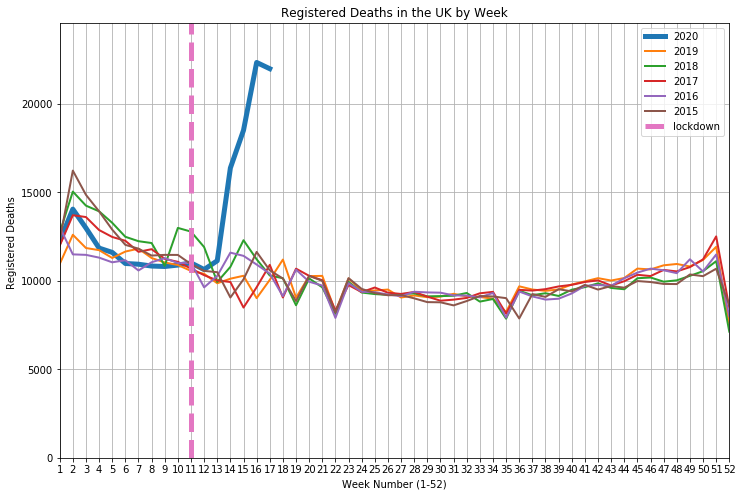

Data: UK Office for National Statistics. Released 5 May, 2020. Includes deaths up to 24 Apr, 2020.


In [31]:
plot_deaths()

#### Plot All Deaths, cumulative

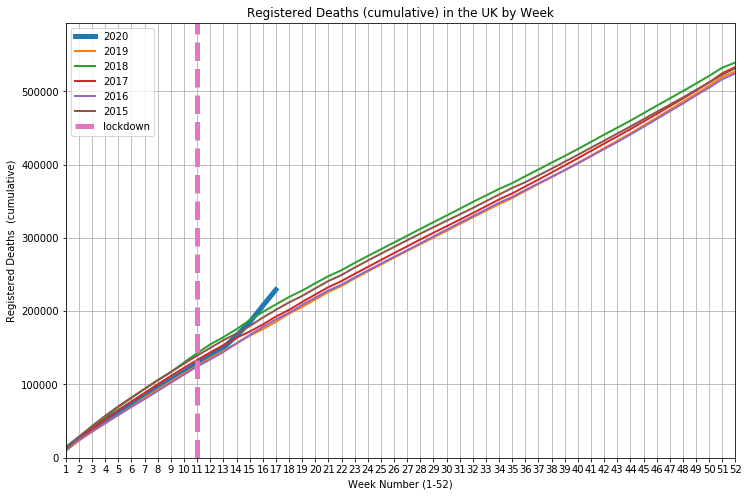

Data: UK Office for National Statistics. Released 5 May, 2020. Includes deaths up to 24 Apr, 2020.


In [32]:
plot_deaths(cumulative=True)

#### Plot Deaths by Age, weekly

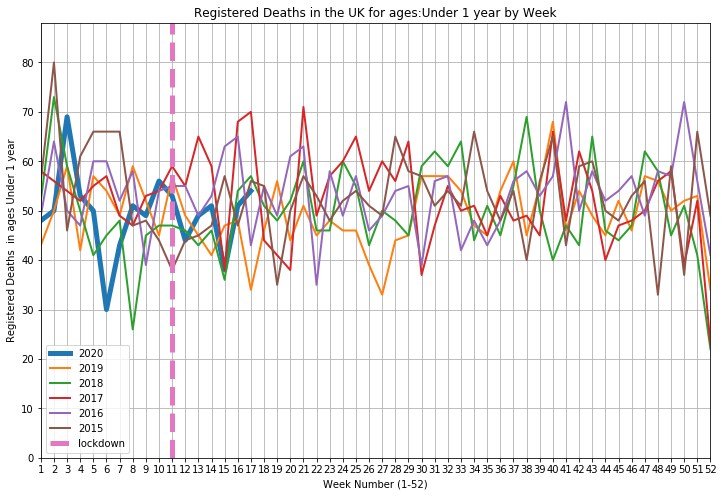

Data: UK Office for National Statistics. Released 5 May, 2020. Includes deaths up to 24 Apr, 2020.


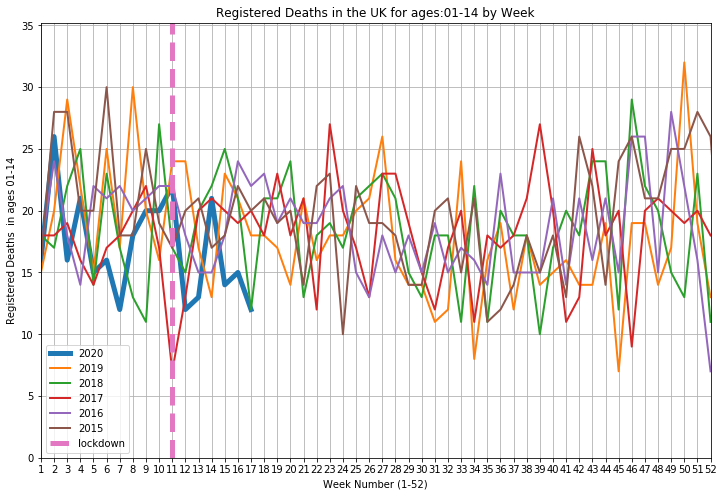

Data: UK Office for National Statistics. Released 5 May, 2020. Includes deaths up to 24 Apr, 2020.


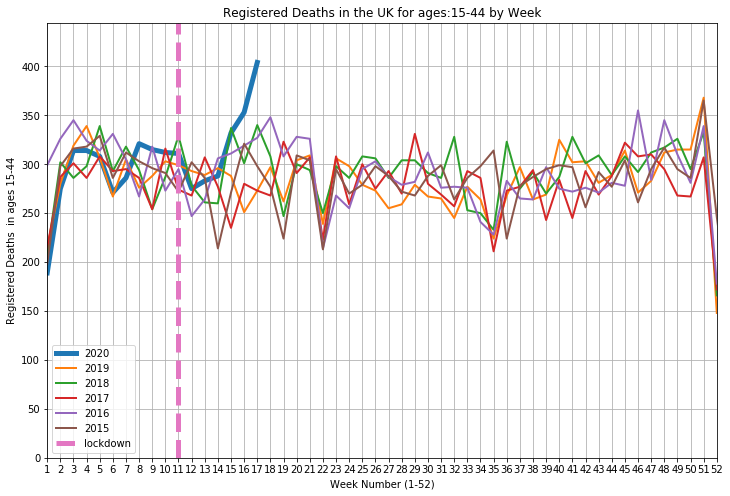

Data: UK Office for National Statistics. Released 5 May, 2020. Includes deaths up to 24 Apr, 2020.


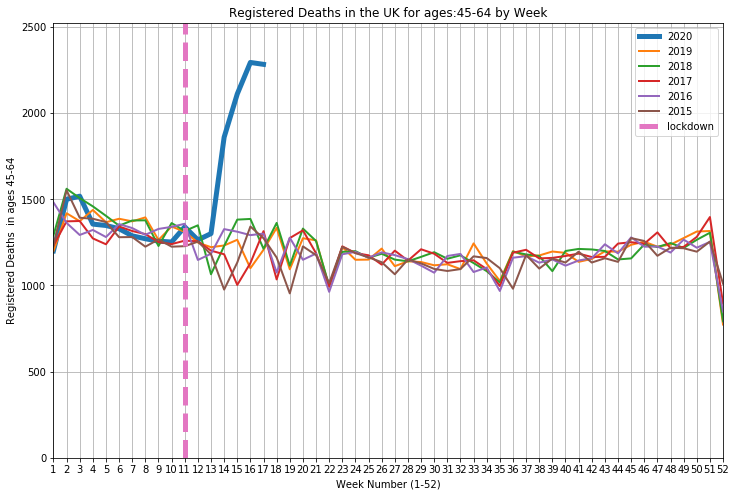

Data: UK Office for National Statistics. Released 5 May, 2020. Includes deaths up to 24 Apr, 2020.


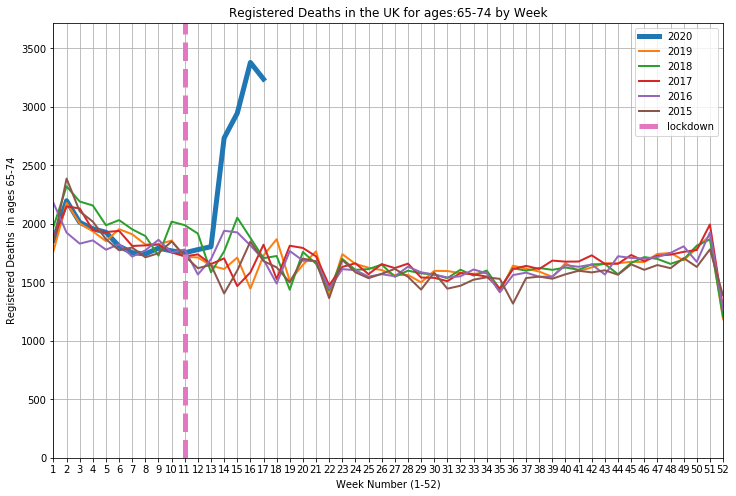

Data: UK Office for National Statistics. Released 5 May, 2020. Includes deaths up to 24 Apr, 2020.


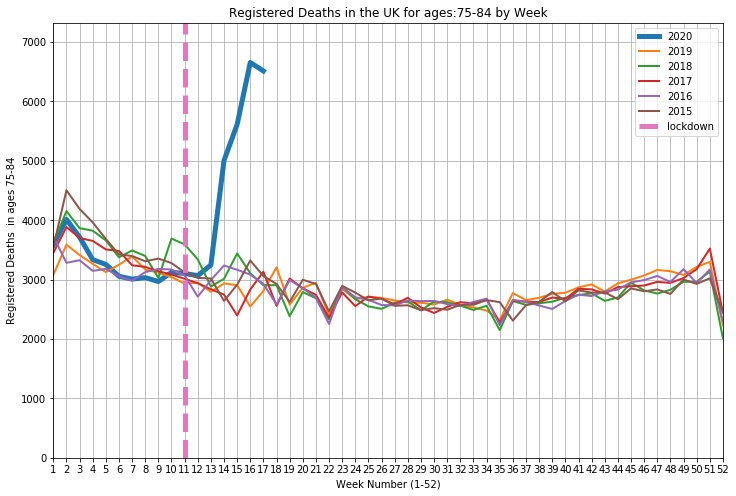

Data: UK Office for National Statistics. Released 5 May, 2020. Includes deaths up to 24 Apr, 2020.


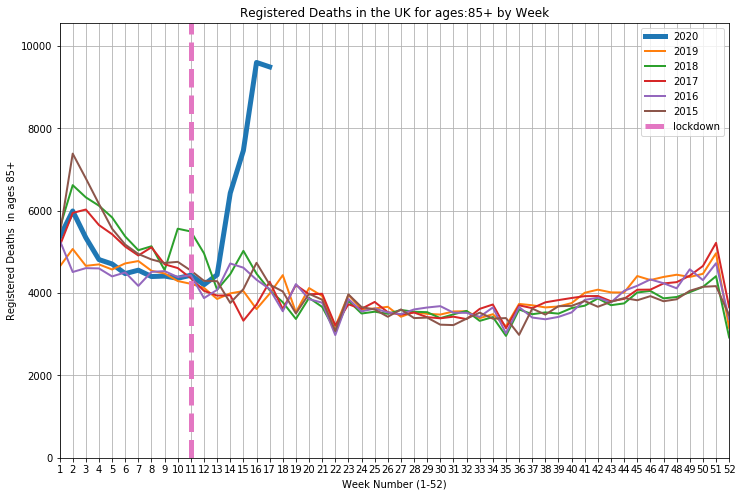

Data: UK Office for National Statistics. Released 5 May, 2020. Includes deaths up to 24 Apr, 2020.


In [33]:
for age in ages:
    plot_deaths('age', age)

#### Plot Deaths by Age, cumulative

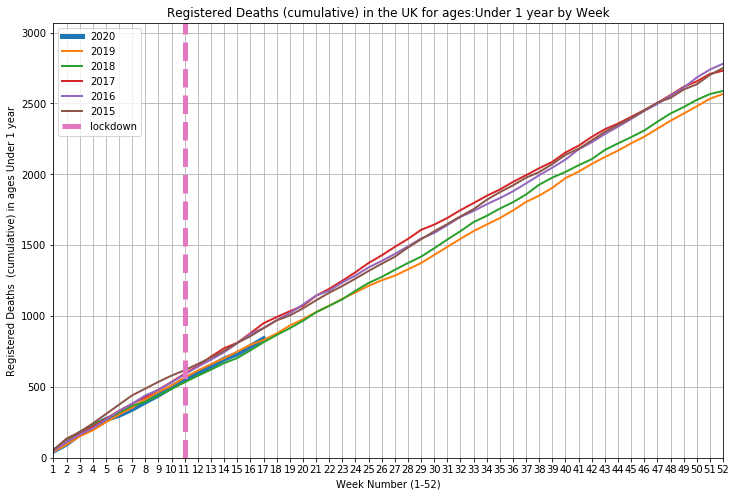

Data: UK Office for National Statistics. Released 5 May, 2020. Includes deaths up to 24 Apr, 2020.


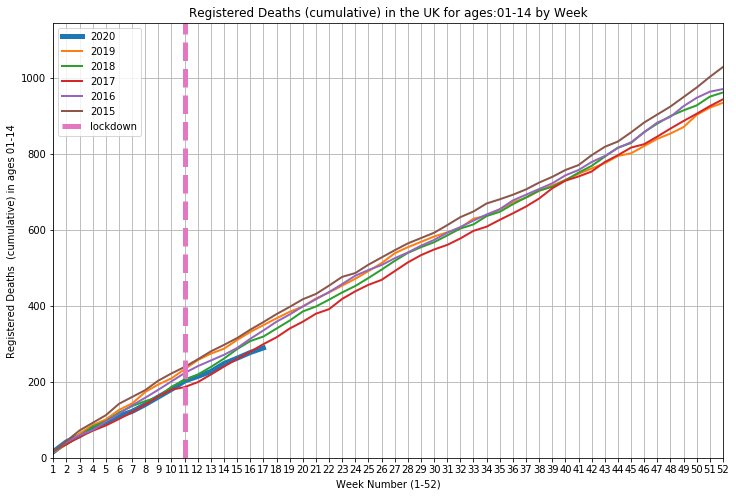

Data: UK Office for National Statistics. Released 5 May, 2020. Includes deaths up to 24 Apr, 2020.


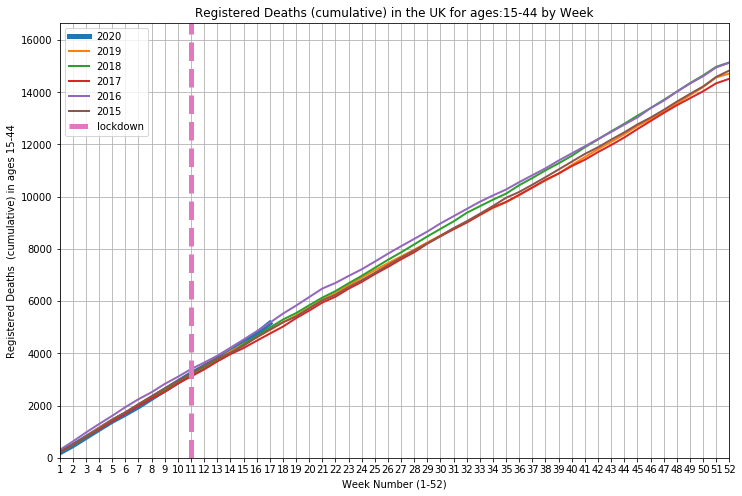

Data: UK Office for National Statistics. Released 5 May, 2020. Includes deaths up to 24 Apr, 2020.


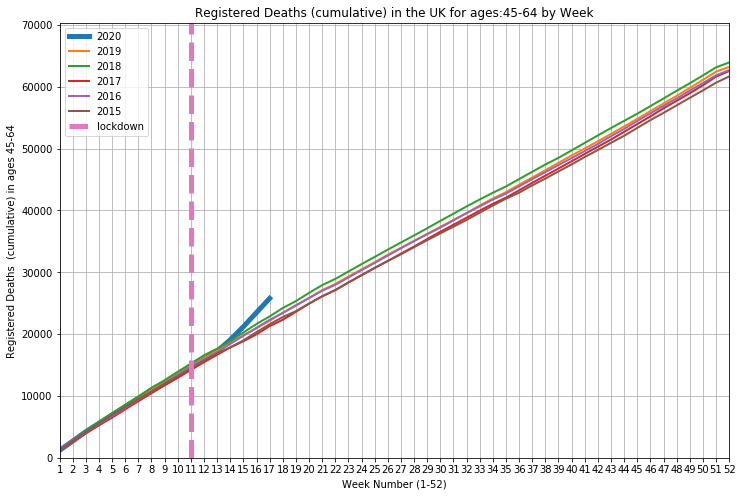

Data: UK Office for National Statistics. Released 5 May, 2020. Includes deaths up to 24 Apr, 2020.


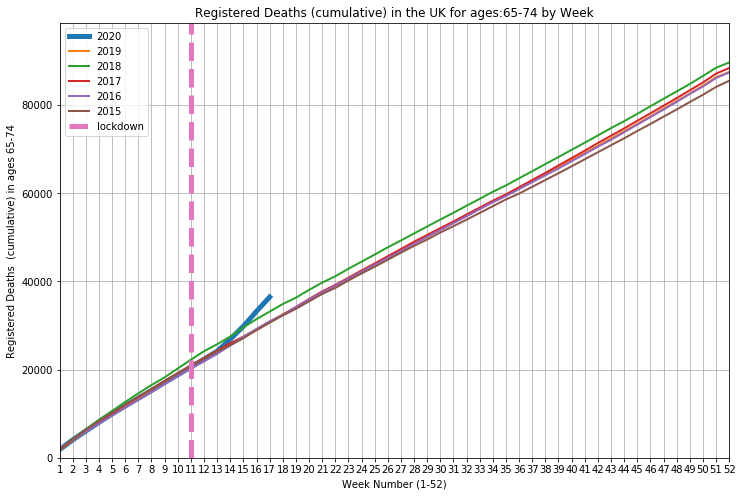

Data: UK Office for National Statistics. Released 5 May, 2020. Includes deaths up to 24 Apr, 2020.


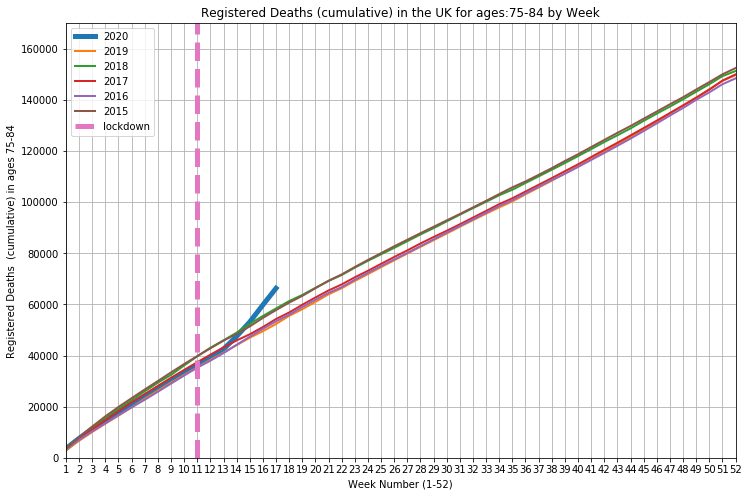

Data: UK Office for National Statistics. Released 5 May, 2020. Includes deaths up to 24 Apr, 2020.


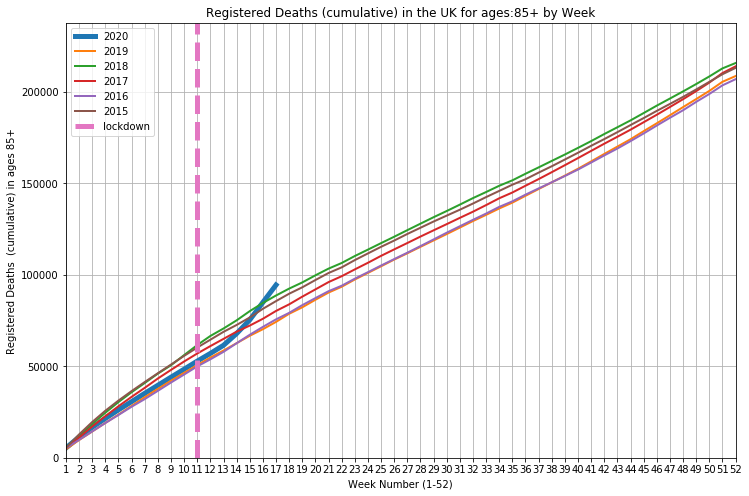

Data: UK Office for National Statistics. Released 5 May, 2020. Includes deaths up to 24 Apr, 2020.


In [34]:
for age in ages:
    plot_deaths('age', age, cumulative=True)

#### Plot Deaths by Location, weekly

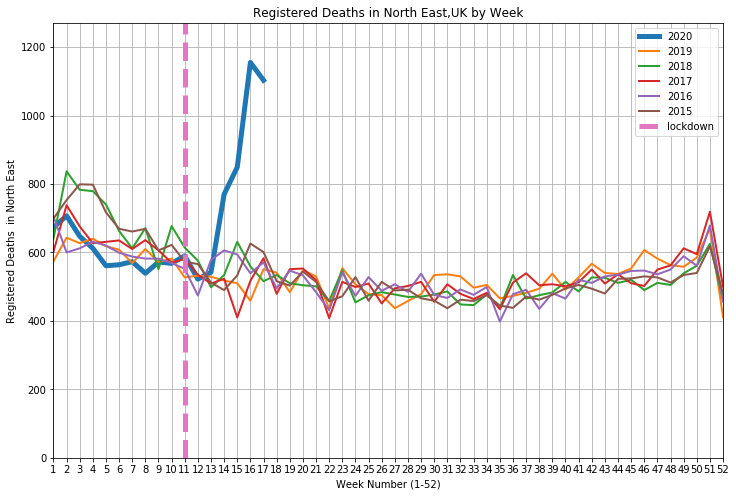

Data: UK Office for National Statistics. Released 5 May, 2020. Includes deaths up to 24 Apr, 2020.


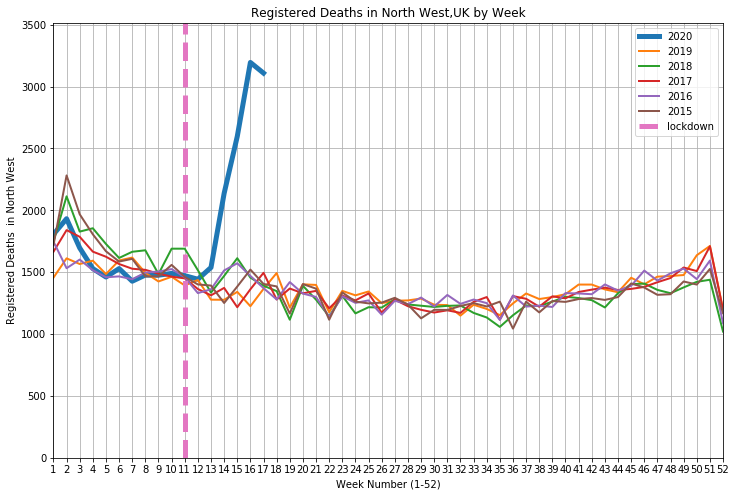

Data: UK Office for National Statistics. Released 5 May, 2020. Includes deaths up to 24 Apr, 2020.


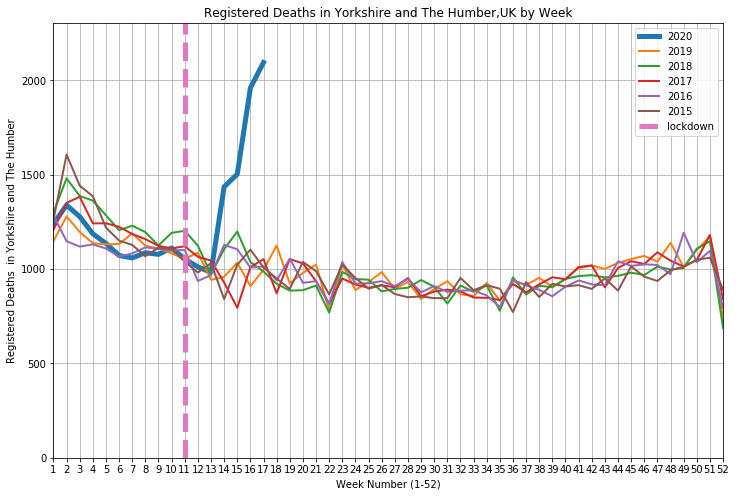

Data: UK Office for National Statistics. Released 5 May, 2020. Includes deaths up to 24 Apr, 2020.


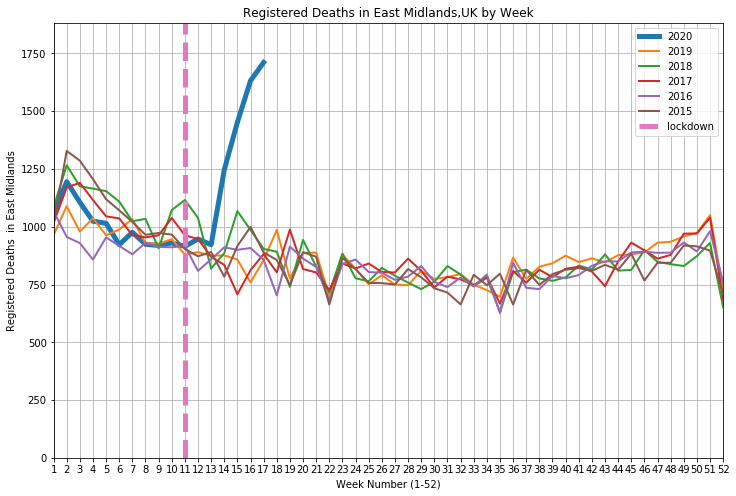

Data: UK Office for National Statistics. Released 5 May, 2020. Includes deaths up to 24 Apr, 2020.


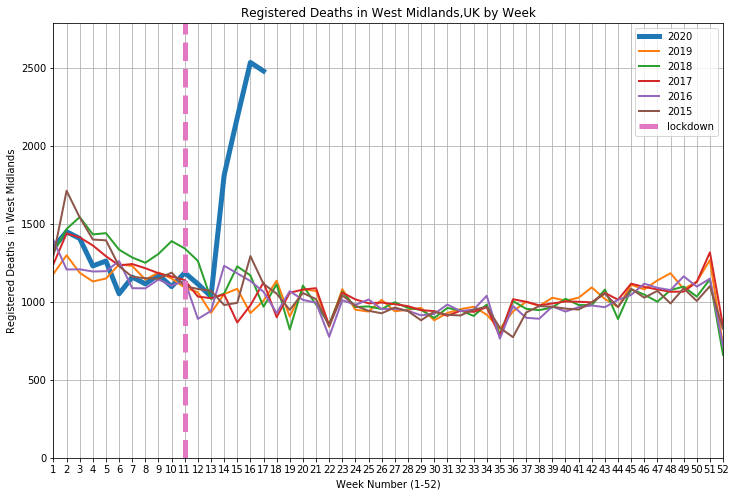

Data: UK Office for National Statistics. Released 5 May, 2020. Includes deaths up to 24 Apr, 2020.


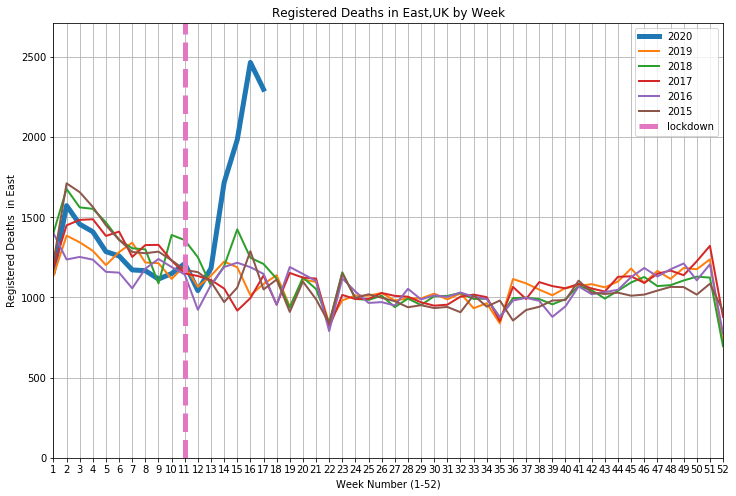

Data: UK Office for National Statistics. Released 5 May, 2020. Includes deaths up to 24 Apr, 2020.


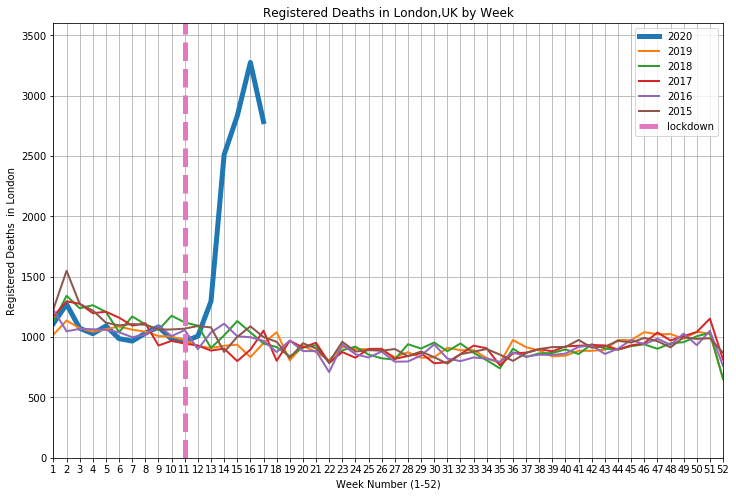

Data: UK Office for National Statistics. Released 5 May, 2020. Includes deaths up to 24 Apr, 2020.


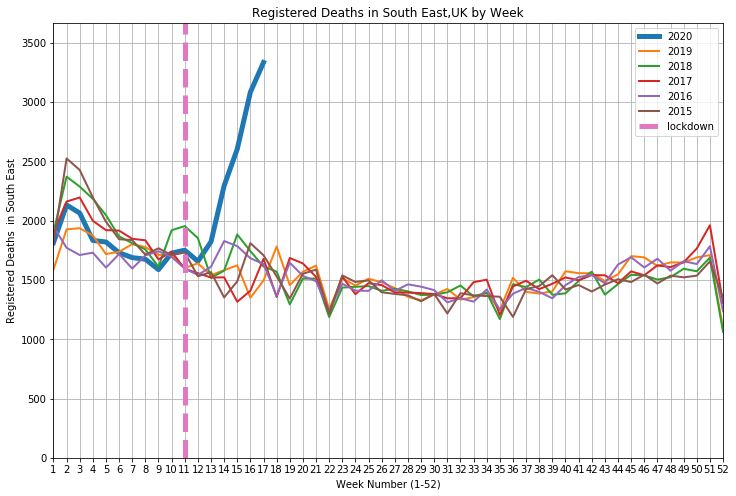

Data: UK Office for National Statistics. Released 5 May, 2020. Includes deaths up to 24 Apr, 2020.


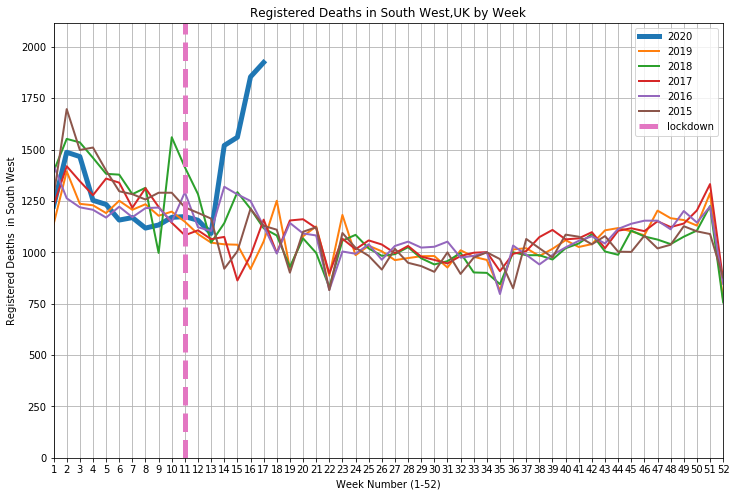

Data: UK Office for National Statistics. Released 5 May, 2020. Includes deaths up to 24 Apr, 2020.


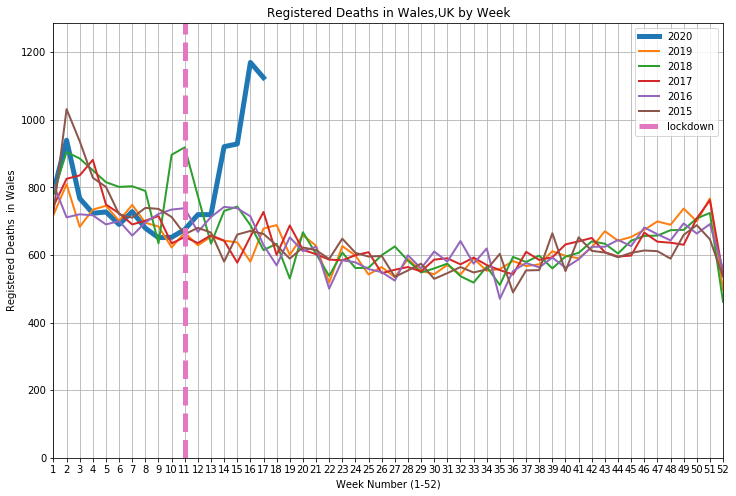

Data: UK Office for National Statistics. Released 5 May, 2020. Includes deaths up to 24 Apr, 2020.


In [35]:
for loc in locations:
    plot_deaths('location', loc)

#### Plot Deaths by Location, cumulative

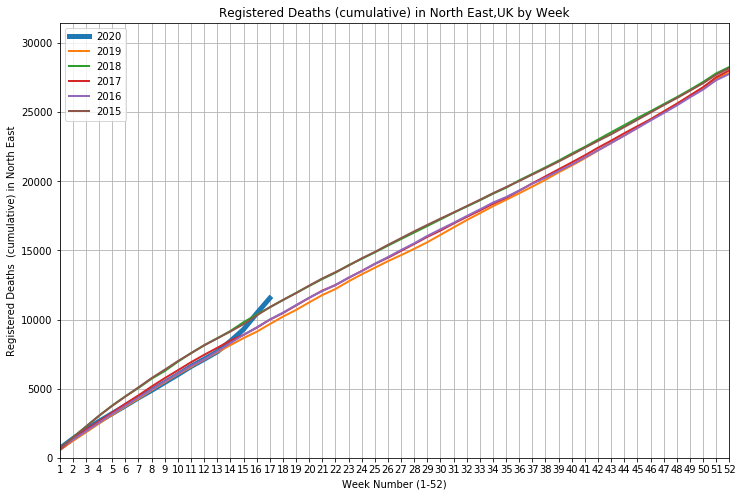

Data: UK Office for National Statistics. Released 5 May, 2020. Includes deaths up to 24 Apr, 2020.


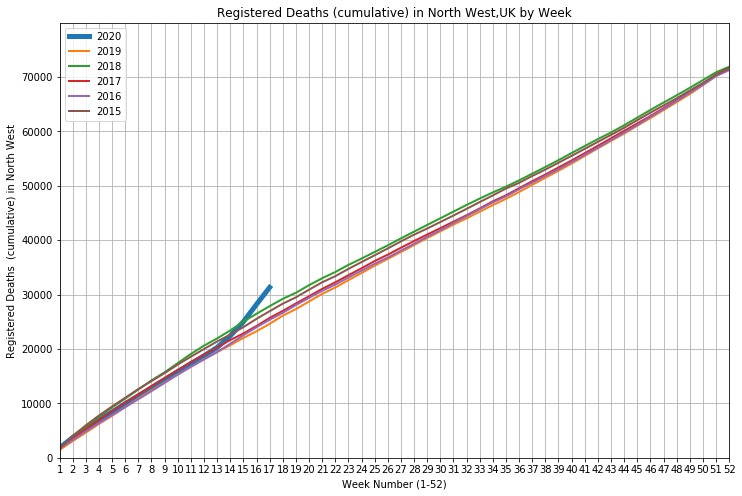

Data: UK Office for National Statistics. Released 5 May, 2020. Includes deaths up to 24 Apr, 2020.


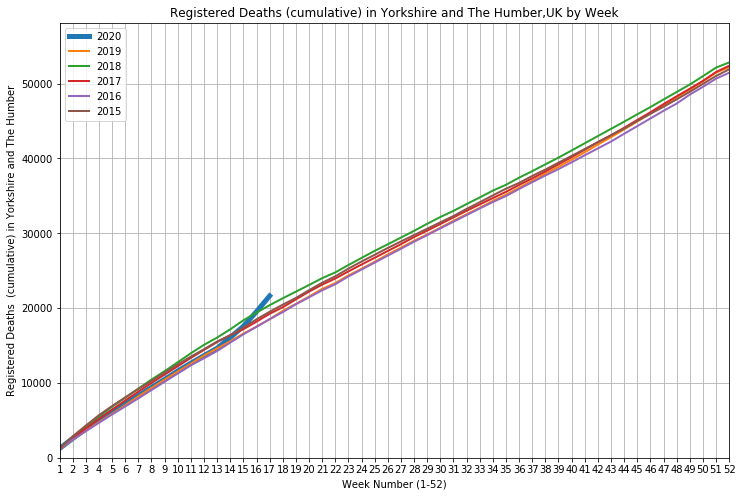

Data: UK Office for National Statistics. Released 5 May, 2020. Includes deaths up to 24 Apr, 2020.


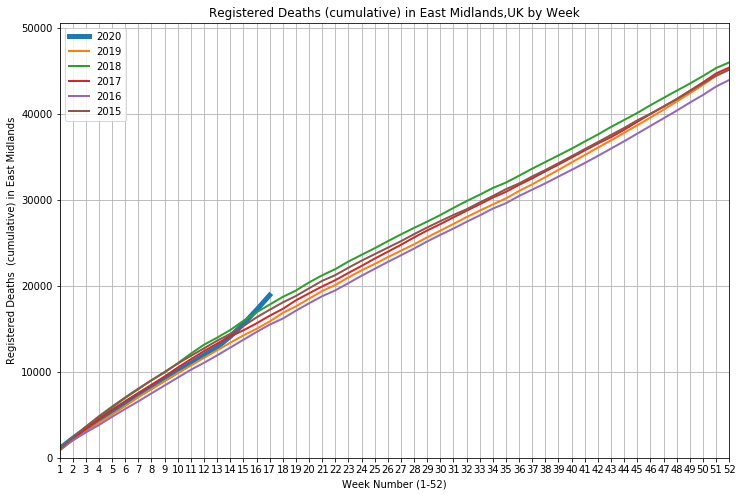

Data: UK Office for National Statistics. Released 5 May, 2020. Includes deaths up to 24 Apr, 2020.


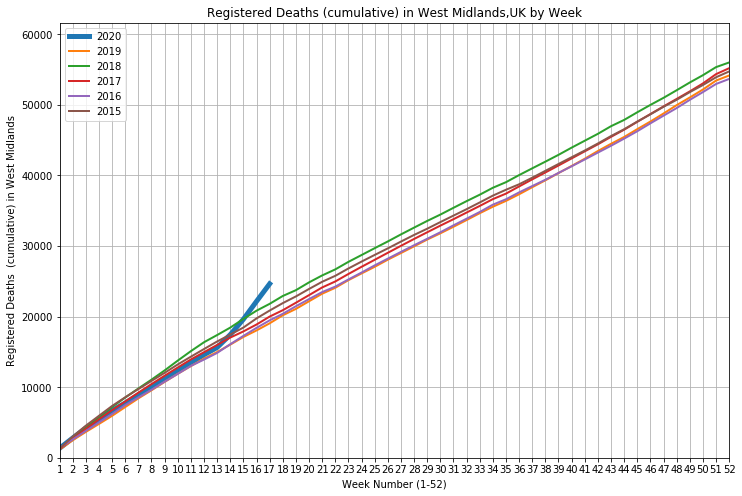

Data: UK Office for National Statistics. Released 5 May, 2020. Includes deaths up to 24 Apr, 2020.


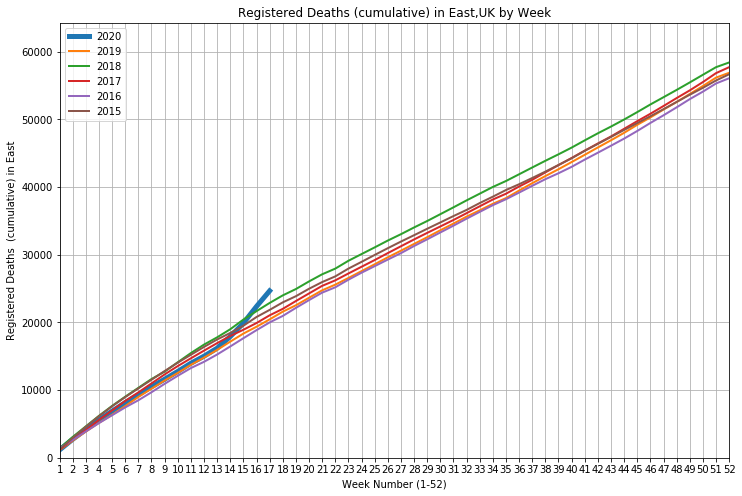

Data: UK Office for National Statistics. Released 5 May, 2020. Includes deaths up to 24 Apr, 2020.


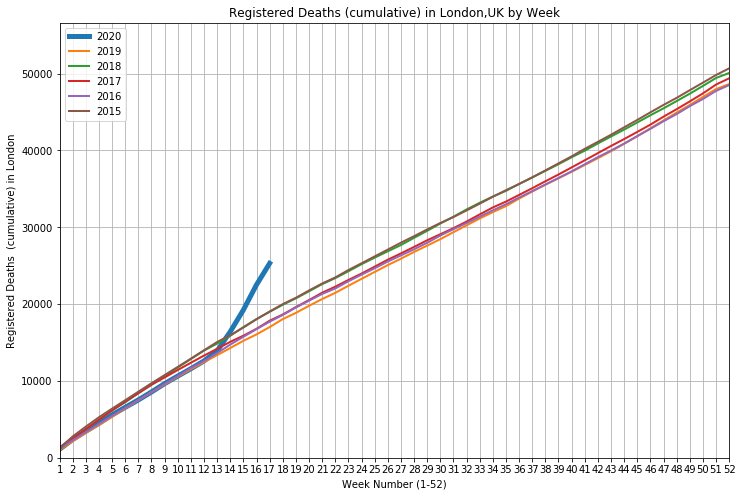

Data: UK Office for National Statistics. Released 5 May, 2020. Includes deaths up to 24 Apr, 2020.


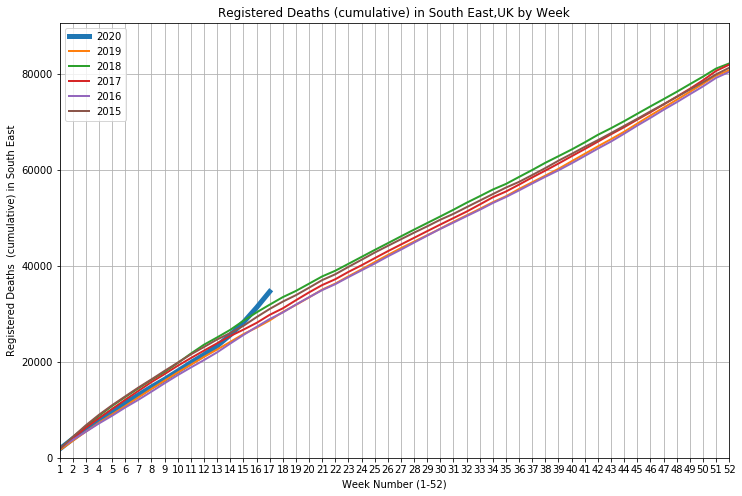

Data: UK Office for National Statistics. Released 5 May, 2020. Includes deaths up to 24 Apr, 2020.


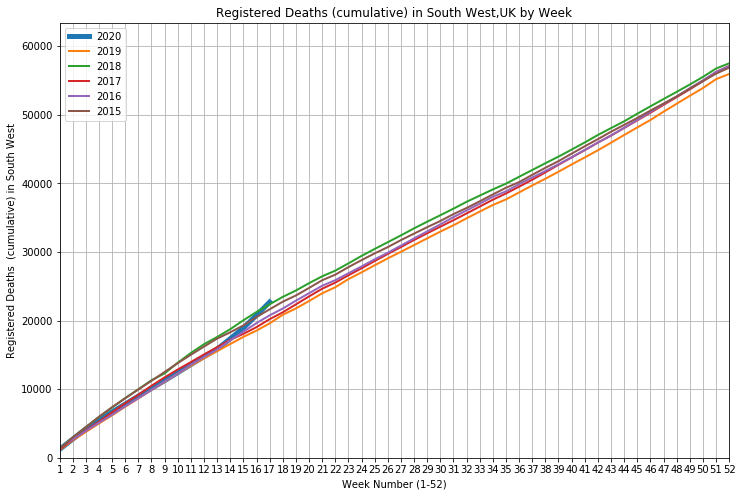

Data: UK Office for National Statistics. Released 5 May, 2020. Includes deaths up to 24 Apr, 2020.


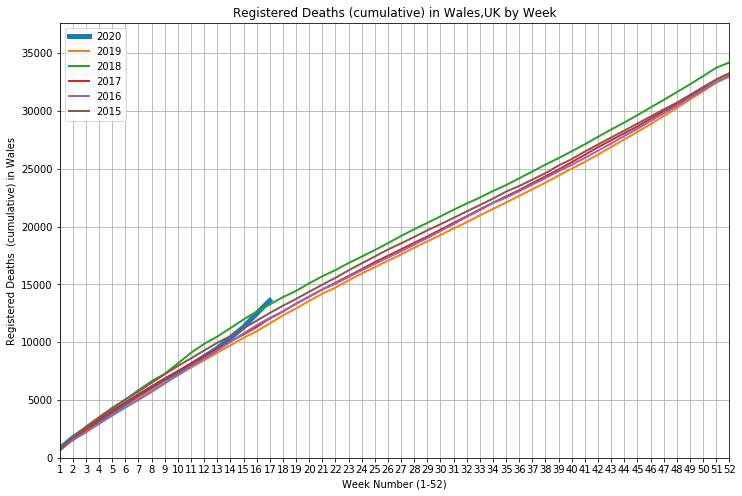

Data: UK Office for National Statistics. Released 5 May, 2020. Includes deaths up to 24 Apr, 2020.


In [36]:
for loc in locations:
    plot_deaths('location', loc, cumulative=True, lockdown=False)

#### Plot Excess Deaths by Age (experimental)

In [37]:
curr_wk = len(deaths_total[2020][0])-1
curr_wk

16

In [38]:
age2cat = {0: 'Under 1 year'}
for age in range(1,15): age2cat[age] = '01-14'
for age in range(15,45): age2cat[age] = '15-44'
for age in range(45,65): age2cat[age] = '45-64'
for age in range(65,75): age2cat[age] = '65-74'
for age in range(75,85): age2cat[age] = '75-84'
for age in range(85,101): age2cat[age] = '85+'

In [39]:
def rel_incr_risk_by_age(comparison_year, start_wk=0):
    ytd_deaths_by_age_5yrs = {}
    ytd_excess_by_age = {}

    for age in ages:
        curr = sum(deaths_by_age[comparison_year][age][start_wk:1+curr_wk])

        avg_yrs = range(2015,comparison_year)
        avg5 = sum(sum([deaths_by_age[y][age][start_wk:1+curr_wk] for y in avg_yrs])) / len(avg_yrs)

        ytd_deaths_by_age_5yrs[age] = avg5
        ytd_excess_by_age[age] = curr - avg5

    ytd_deaths_by_age_comparison_year = {k:v for k,v in deaths_by_age[comparison_year][start_wk:1+curr_wk].sum().items()}

    relative_increase_risk_by_age = {age: ytd_excess_by_age[age] / ytd_deaths_by_age_5yrs[age] * 100 for age in ages}
    ytd_excess_by_age, ytd_deaths_by_age_comparison_year, ytd_deaths_by_age_5yrs, relative_increase_risk_by_age
    return relative_increase_risk_by_age

In [61]:
def plot_rel_increase_death(comparison_year, window_size=1, start_wk=0):
    relative_increase_risk_by_age = rel_incr_risk_by_age(comparison_year, start_wk=start_wk)
    
    plt.figure(figsize=(12,8))
    plt.title(f'Relative Increase in Risk of All-Cause Death by Age Group in England and Wales ({comparison_year} vs. prior 5 years)')
    x = age2cat.keys()
    y = [np.mean([relative_increase_risk_by_age[age2cat[a]] 
                  for a in range(age-window_size//2,age+window_size//2+1) 
                  if a >= 0 and a <=100])
         for age in range(0,101)]
    plt.bar(x, y, width=1)
    plt.plot([0,100],[0,0],'r')
    plt.plot([0,100],[-.1,-.1],'g')
    plt.grid()
    plt.xlabel('Age')
    plt.ylim(-80,80)
    if window_size == 1:
        plt.ylabel('Relative Increase in Risk of Death (%)')
    else:
        plt.ylabel(f'Relative Increase in Risk of Death (%, {window_size} yr sliding window)')
    plt.show()
    print("Data: UK Office for National Statistics - Registered Deaths, published on 5 May, 2020. \nIncludes deaths up to 25 Apr, 2020.")
    if start_wk != 0:
        print(f'Relative increase in risk calculated by comparing total deaths during weeks {start_wk} to {curr_wk} in \n{comparison_year} with same period averaged over the previous 5 years.')

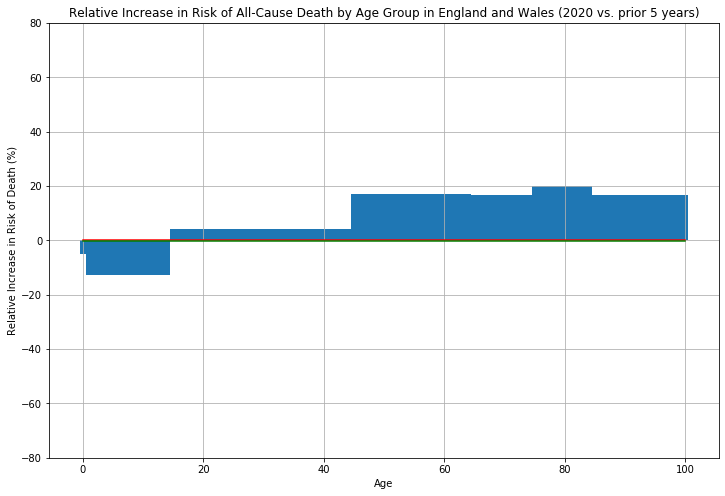

Data: UK Office for National Statistics - Registered Deaths, published on 5 May, 2020. 
Includes deaths up to 25 Apr, 2020.


In [62]:
plot_rel_increase_death(2020)

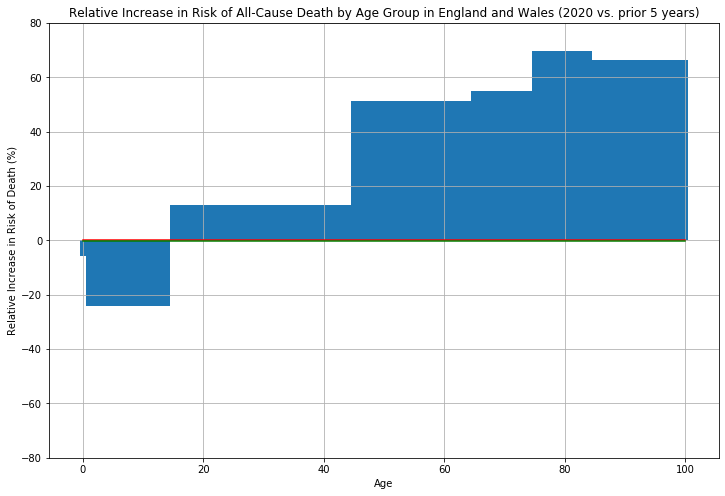

Data: UK Office for National Statistics - Registered Deaths, published on 5 May, 2020. 
Includes deaths up to 25 Apr, 2020.
Relative increase in risk calculated by comparing total deaths during weeks 11 to 16 in 
2020 with same period averaged over the previous 5 years.


In [63]:
plot_rel_increase_death(2020, start_wk=11)

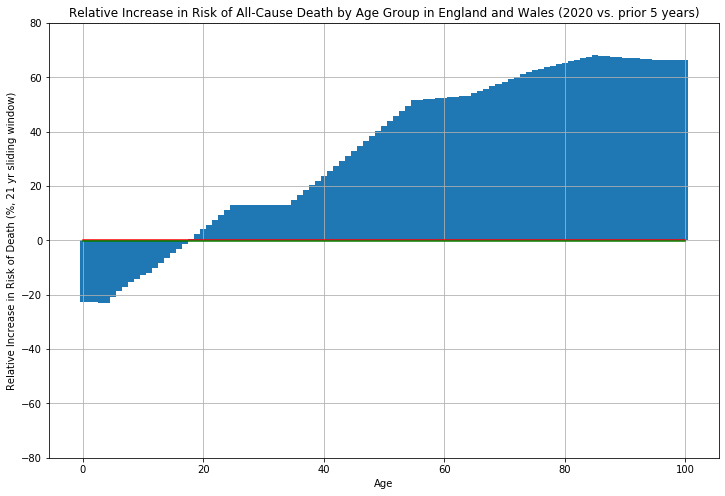

Data: UK Office for National Statistics - Registered Deaths, published on 5 May, 2020. 
Includes deaths up to 25 Apr, 2020.
Relative increase in risk calculated by comparing total deaths during weeks 11 to 16 in 
2020 with same period averaged over the previous 5 years.


In [64]:
plot_rel_increase_death(2020, start_wk=11, window_size=21)

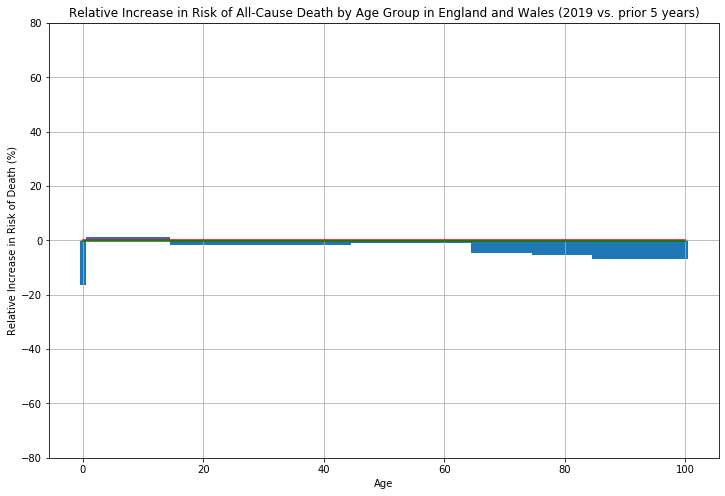

Data: UK Office for National Statistics - Registered Deaths, published on 5 May, 2020. 
Includes deaths up to 25 Apr, 2020.
Relative increase in risk calculated by comparing total deaths during weeks 11 to 16 in 
2019 with same period averaged over the previous 5 years.


In [65]:
plot_rel_increase_death(2019, start_wk=11)

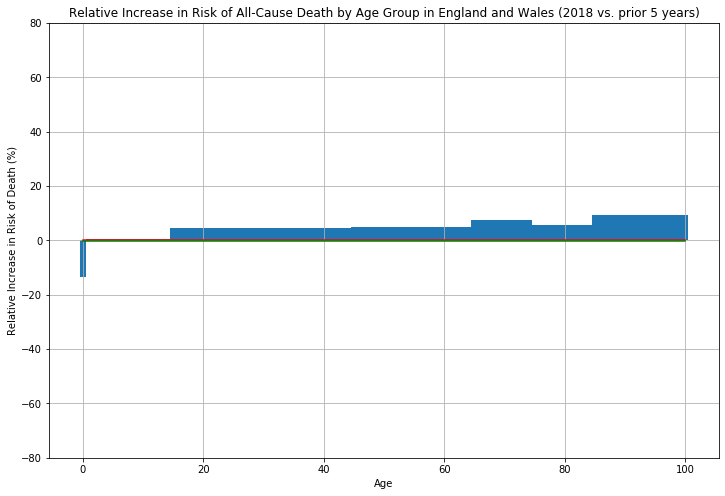

Data: UK Office for National Statistics - Registered Deaths, published on 5 May, 2020. 
Includes deaths up to 25 Apr, 2020.
Relative increase in risk calculated by comparing total deaths during weeks 11 to 16 in 
2018 with same period averaged over the previous 5 years.


In [66]:
plot_rel_increase_death(2018, start_wk=11)

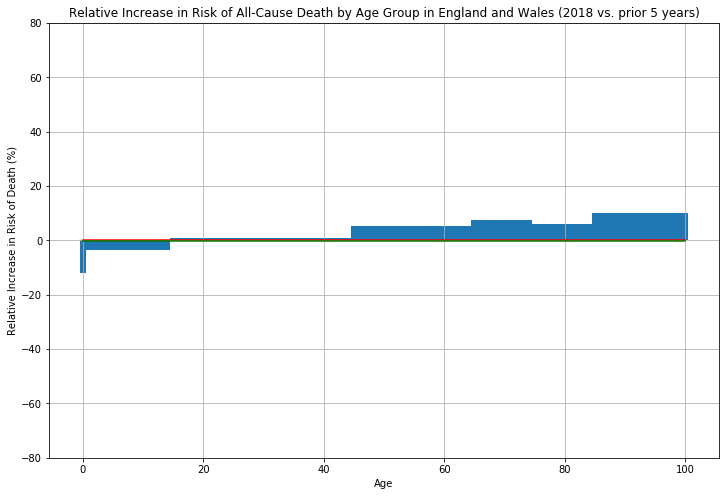

Data: UK Office for National Statistics - Registered Deaths, published on 5 May, 2020. 
Includes deaths up to 25 Apr, 2020.


In [67]:
plot_rel_increase_death(2018)

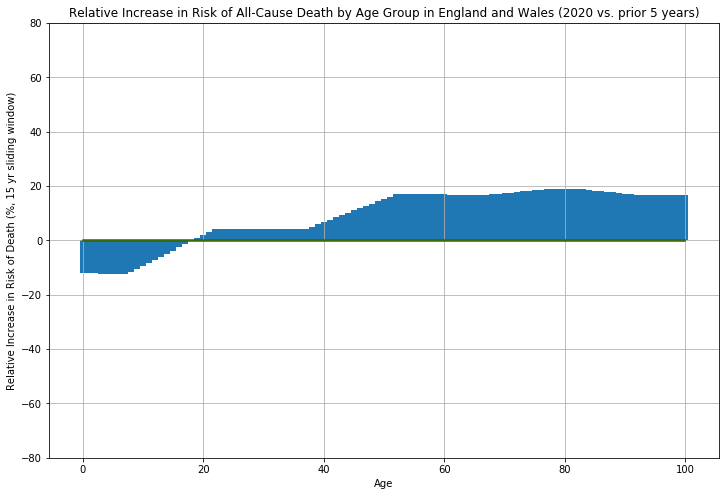

Data: UK Office for National Statistics - Registered Deaths, published on 5 May, 2020. 
Includes deaths up to 25 Apr, 2020.


In [68]:
plot_rel_increase_death(2020, window_size=15)

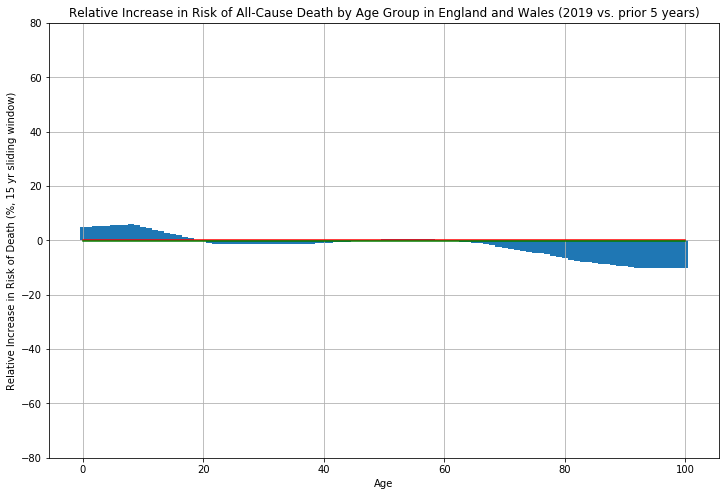

Data: UK Office for National Statistics - Registered Deaths, published on 5 May, 2020. 
Includes deaths up to 25 Apr, 2020.


In [69]:
plot_rel_increase_death(2019, window_size=15)

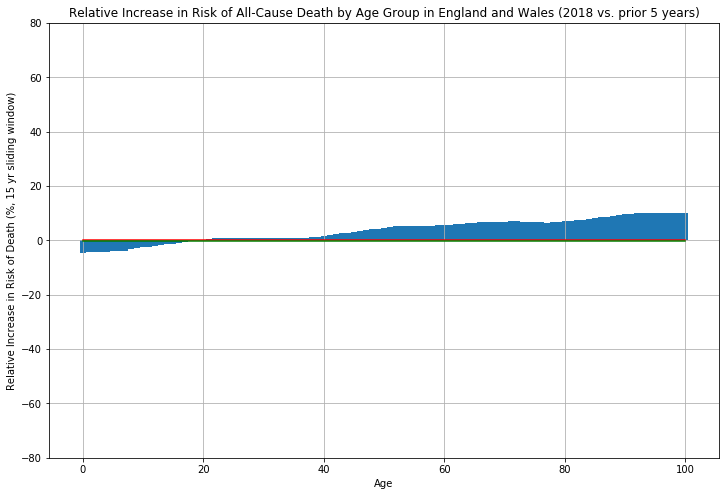

Data: UK Office for National Statistics - Registered Deaths, published on 5 May, 2020. 
Includes deaths up to 25 Apr, 2020.


In [70]:
plot_rel_increase_death(2018, window_size=15)

## Summary
<a id='summary'></a>

Update: May 5, 2020
 - Overall there are approximately the same or fewer deaths this week compared to the last. The London region looks like a more definitive reduction in deaths and four regions are showing an increase in deaths (Yorkshire and Humber, East Midlands, South West, South East).

Update: April 28, 2020
 - Continuation of the trend of cumulative deaths this year outpacing previous years.
 - Possible slow down last week appears to have disappeared.

Update: April 14, 2020
 - A clear uptick in weekly deaths is now obeservable in all groups except for ages <44
 - Plots of cumulative (i.e. year-to-date) deaths now show that this year started out on the low end and is now on the high end.

April 13, 2020:
 - ONS says that there is approximately a 5 day lag between the actual death date and the date the death is registered. This data shows the date of death registration.
 - London deaths is the only plot examined that stands out as markedly above the normal yearly variation, starting at week 13.
 - London cumulative deaths shows no clear uptick. This is likely to be at least partially due to the comparatively mild 2019-2020 winter.
 - The UK Office of National Statistics releases the next week of data on April 14, 2020. This is when COVID-19 deaths really started to pick up so I anticipate that this will be reflected in the 

In [53]:
curr_wk = len(deaths_total[2020][0])-1
curr_wk

16

In [54]:
curr = deaths_total[2020][0][curr_wk]
avg5 = sum([deaths_total[y][0][curr_wk] for y in range(2015,2020)]) / len(range(2015,2020))
curr, avg5, (curr - avg5) / curr

(21997, 10457.0, 0.524616993226349)

In [55]:
curr = deaths_total[2020][0][-1]
avg5 = sum([deaths_total[y][0][curr_wk] for y in range(2015,2020)]) / len(range(2015,2020))
curr, avg5, (curr - avg5) / curr

(21997, 10457.0, 0.524616993226349)

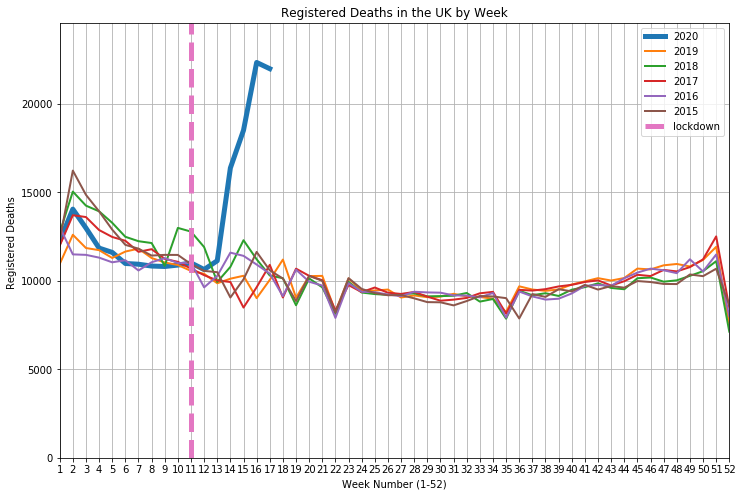

Data: UK Office for National Statistics. Released 5 May, 2020. Includes deaths up to 24 Apr, 2020.


In [56]:
plot_deaths()

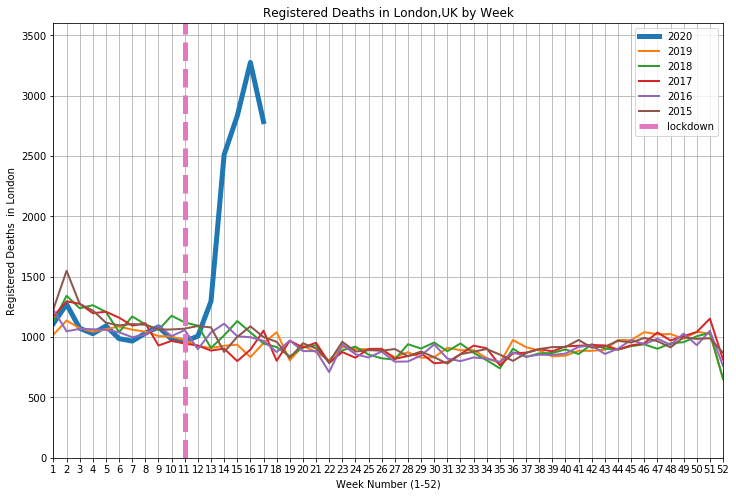

Data: UK Office for National Statistics. Released 5 May, 2020. Includes deaths up to 24 Apr, 2020.


In [57]:
plot_deaths('location', 'London')

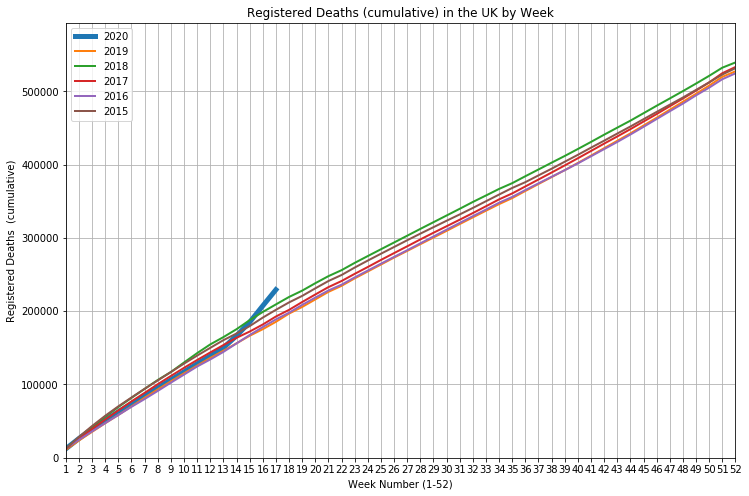

Data: UK Office for National Statistics. Released 5 May, 2020. Includes deaths up to 24 Apr, 2020.


In [58]:
plot_deaths(cumulative=True, lockdown=False)

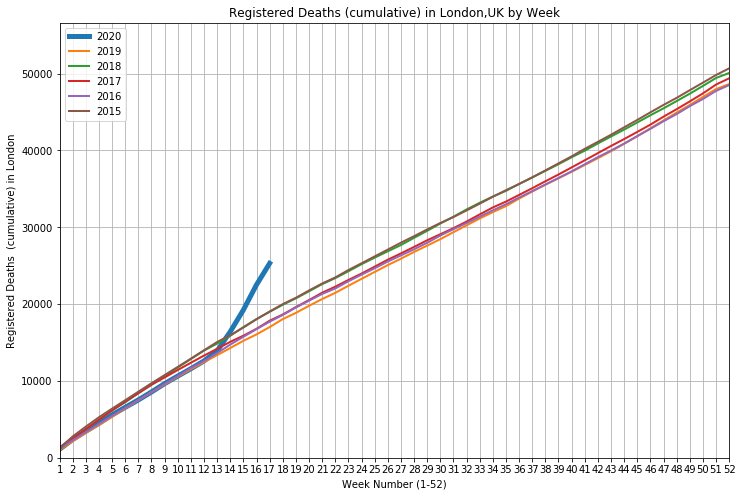

Data: UK Office for National Statistics. Released 5 May, 2020. Includes deaths up to 24 Apr, 2020.


In [59]:
plot_deaths('location', 'London', cumulative=True, lockdown=False)

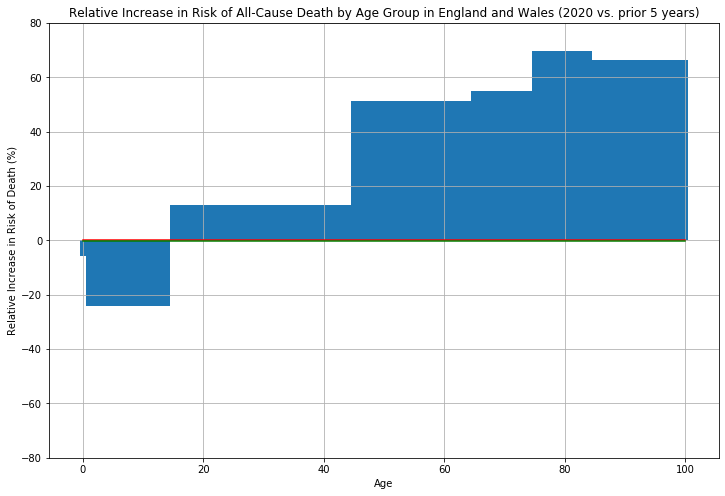

Data: UK Office for National Statistics - Registered Deaths, published on 28 Apr, 2020. 
Includes deaths up to 17 Apr, 2020.
Relative increase in risk calculated by comparing total deaths during weeks 11 to 16 in 
2020 with same period averaged over the previous 5 years.


In [60]:
plot_rel_increase_death(2020, start_wk=11)

## What to do next?

 - add next week of data (available 12 May, 2020)
 - add COVID-19 death data for comparison, expect ~5 day lag in data due to avg time between death and registration (according to ONS)